# Library

In [3]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# GPU 용량 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data Load

In [3]:
m1 = pd.read_csv('method1_df.csv')
m2 = pd.read_csv('method2_df.csv')

# RF 정확도 함수

In [52]:
def RF_정확도(itemlist,name):

    # itemlist만을 가진 x_(7727,10)_itemlist 만들기
    item_list = list(total_data['ITEMID'].sort_values().unique())
    
    item_index = []
    for i in itemlist:
        item_index.append(item_list.index(i))

    print('itemlist의 index : ',item_index)

    x = np.load('x_(7727,4068).npy')
    x_2d = x[:,item_index]
    x_2d
    
    np.save(f'x_(7727,10)_{name}.npy',x_2d)
    
    import random
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    model = RandomForestClassifier()

    data={}
    for seed in range(42, 52):
        random.seed(seed)
        
        x = np.load(f'./x_(7727,10)_{name}.npy')
        y = np.load('./y_(7727,1).npy')

        idx = list(range(len(x)))
        random.shuffle(idx)

        i = round(x.shape[0]*0.8)
        X_train, y_train = x[idx[:i],:], y[idx[:i]]
        X_test, y_test = x[idx[i:],:], y[idx[i:]]

        _ = model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred_test)
        data[seed]=acc
        print(f'정확도 : {acc}, seed_num = {seed}')

    df = pd.DataFrame.from_dict(data, orient='index')
    print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')    

# LSTM 정확도 함수

In [67]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random

def LSTM_정확도(itemlist, name):

    # itemlist만을 가진 x_(7727,10,10)_itemlist 만들기
    total_data = pd.read_csv('total_data_7727.csv')
    item_list = list(total_data['ITEMID'].sort_values().unique())

    item_index = []
    for i in itemlist:
        item_index.append(item_list.index(i))

    print('itemlist의 index : ',item_index)

    x = np.load('x_(7727,10,4068).npy')
    x_3d = x[:,:,item_index]
    
    np.save(f'x_(7727,10,10)_{name}.npy',x_3d)
    
    seed_num = 42
    random.seed(seed_num)
    
    x = np.load(f'x_(7727,10,10)_{name}.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

    # ---------------------
    seed_num = 42 
    # ---------------------
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))

    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./model/{name}'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + f'/{name}_seed42-'+'{epoch:02d}'+'-{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)
    
    with tf.device('/device:GPU:0'):
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

        from pathlib import Path
        paths = sorted(Path(MODEL_SAVE_FOLDER_PATH).iterdir(), key=os.path.getmtime)[-1]
        best_model_path = str(paths)

        from keras.models import load_model
        best_model = load_model(best_model_path) 

        dic_42={}
        for seed in range(0, 50):
            random.seed(seed)

            x = np.load(f'x_(7727,10,10)_{name}.npy')
            y = np.load('y_(7727,1).npy')

            idx = list(range(len(x)))
            random.shuffle(idx)

            i = round(x.shape[0]*0.8)
            X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
            X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

            pred = best_model.predict(X_test)
            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            acc = metrics.accuracy_score(y_test, pred)
            dic_42[seed]=acc
            print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

        df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
        print(f'정확도 df 만들고 평균 확인 : {df_42.mean().values}')

# Method 1 : 상위 10개 feature
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [4]:
m1['abs'] = abs(m1['mul'])
m1 = m1.sort_values(by='abs', ascending=False)
m1_top10 = m1['feature'].values[:10]
m1_top10

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
            227194,    54858516,    74706811,    45006701,     4003822])

## (65.1) RF

In [54]:
# m1_top10만을 가진 x_(7727,10)_m1 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_top10_index]
x_2d.shape

# np.save('x_(7727,10)_m1.npy',x_2d)

m1_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10)

In [53]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6355987055016181, seed_num = 42
정확도 : 0.6330097087378641, seed_num = 43
정확도 : 0.6349514563106796, seed_num = 44
정확도 : 0.6576051779935275, seed_num = 45
정확도 : 0.6466019417475728, seed_num = 46
정확도 : 0.6634304207119741, seed_num = 47
정확도 : 0.6750809061488673, seed_num = 48
정확도 : 0.654368932038835, seed_num = 49
정확도 : 0.6640776699029126, seed_num = 50
정확도 : 0.6511326860841424, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65158576]


## (64.9) LSTM

In [58]:
# m1_top10만을 가진 x_(7727,10,10)_m1 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_m1.npy',x_3d)

m1_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10, 10)

6187.0

In [60]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 6s 55ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/10개 feature/seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 43ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66551, saving model to ./model/10개 feature/seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66551 to 0.66526, saving model to ./model/10개 feature/seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 2s 43ms/step - loss: 0.670

37/37 [==============================] - 2s 44ms/step - loss: 0.6109 - acc: 0.6381 - val_loss: 0.6170 - val_acc: 0.6475

Epoch 00039: val_loss improved from 0.61935 to 0.61702, saving model to ./model/10개 feature/seed42-39-0.6170.hdf5
Epoch 40/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6101 - acc: 0.6372 - val_loss: 0.6157 - val_acc: 0.6481

Epoch 00040: val_loss improved from 0.61702 to 0.61572, saving model to ./model/10개 feature/seed42-40-0.6157.hdf5
Epoch 41/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6077 - acc: 0.6413 - val_loss: 0.6145 - val_acc: 0.6514

Epoch 00041: val_loss improved from 0.61572 to 0.61446, saving model to ./model/10개 feature/seed42-41-0.6145.hdf5
Epoch 42/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6034 - acc: 0.6462 - val_loss: 0.6134 - val_acc: 0.6514

Epoch 00042: val_loss improved from 0.61446 to 0.61336, saving model to ./model/10개 feature/seed42-42-0.6134.hdf5
Epoch 43/500
37/37 [=

37/37 [==============================] - 2s 44ms/step - loss: 0.5987 - acc: 0.6540 - val_loss: 0.6138 - val_acc: 0.6533

Epoch 00081: val_loss did not improve from 0.61251
Epoch 82/500
37/37 [==============================] - 2s 44ms/step - loss: 0.5985 - acc: 0.6540 - val_loss: 0.6154 - val_acc: 0.6533

Epoch 00082: val_loss did not improve from 0.61251
Epoch 83/500
37/37 [==============================] - 2s 44ms/step - loss: 0.5980 - acc: 0.6536 - val_loss: 0.6161 - val_acc: 0.6533

Epoch 00083: val_loss did not improve from 0.61251
Epoch 84/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6000 - acc: 0.6547 - val_loss: 0.6123 - val_acc: 0.6533

Epoch 00084: val_loss improved from 0.61251 to 0.61229, saving model to ./model/10개 feature/seed42-84-0.6123.hdf5
Epoch 85/500
37/37 [==============================] - 2s 44ms/step - loss: 0.5988 - acc: 0.6536 - val_loss: 0.6151 - val_acc: 0.6533

Epoch 00085: val_loss did not improve from 0.61229
Epoch 86/500
37/37 [=====

In [63]:
from keras.models import load_model
best_model = load_model('./model/m1_top10_seed42-84-0.6123.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6466019417475728, seed_num = 0
정확도 :0.6427184466019418, seed_num = 1
정확도 :0.6498381877022654, seed_num = 2
정확도 :0.6375404530744336, seed_num = 3
정확도 :0.654368932038835, seed_num = 4
정확도 :0.655663430420712, seed_num = 5
정확도 :0.6537216828478964, seed_num = 6
정확도 :0.629126213592233, seed_num = 7
정확도 :0.6614886731391586, seed_num = 8
정확도 :0.6498381877022654, seed_num = 9
정확도 :0.627831715210356, seed_num = 10
정확도 :0.6711974110032363, seed_num = 11
정확도 :0.6472491909385113, seed_num = 12
정확도 :0.6414239482200648, seed_num = 13
정확도 :0.6466019417475728, seed_num = 14
정확도 :0.656957928802589, seed_num = 15
정확도 :0.6692556634304208, seed_num = 16
정확도 :0.6453074433656958, seed_num = 17
정확도 :0.6459546925566343, seed_num = 18
정확도 :0.6414239482200648, seed_num = 19
정확도 :0.6601941747572816, seed_num = 20
정확도 :0.6595469255663431, seed_num = 21
정확도 :0.6375404530744336, seed_num = 22
정확도 :0.6550161812297735, seed_num = 23
정확도 :0.6530744336569579, seed_num = 24
정확도 :0.6491909385113268, seed_num = 25
정

In [64]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.649204
dtype: float64

## (64.9) not saved LSTM

In [82]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 4s 46ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177
Epoch 2/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177
Epoch 3/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177
Epoch 4/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177
Epoch 5/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6706 - acc: 0.6091 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 6/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6721 - acc: 0.6113 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 7/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6710 - acc: 0.6111 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 8/500
37/37 [==============================] - 1s 37ms/step - loss: 0.

In [83]:
dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = lstm.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6459546925566343, seed_num = 0
정확도 :0.6427184466019418, seed_num = 1
정확도 :0.6498381877022654, seed_num = 2
정확도 :0.6375404530744336, seed_num = 3
정확도 :0.654368932038835, seed_num = 4
정확도 :0.655663430420712, seed_num = 5
정확도 :0.6537216828478964, seed_num = 6
정확도 :0.629126213592233, seed_num = 7
정확도 :0.6614886731391586, seed_num = 8
정확도 :0.6491909385113268, seed_num = 9
정확도 :0.627831715210356, seed_num = 10
정확도 :0.6711974110032363, seed_num = 11
정확도 :0.6472491909385113, seed_num = 12
정확도 :0.6414239482200648, seed_num = 13
정확도 :0.6466019417475728, seed_num = 14
정확도 :0.6563106796116505, seed_num = 15
정확도 :0.6692556634304208, seed_num = 16
정확도 :0.6446601941747573, seed_num = 17
정확도 :0.6453074433656958, seed_num = 18
정확도 :0.6414239482200648, seed_num = 19
정확도 :0.6601941747572816, seed_num = 20
정확도 :0.6588996763754046, seed_num = 21
정확도 :0.6375404530744336, seed_num = 22
정확도 :0.6550161812297735, seed_num = 23
정확도 :0.6530744336569579, seed_num = 24
정확도 :0.6491909385113268, seed_num = 25


In [84]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.64901
dtype: float64

# RF : 상위 10개 feature 
- x_(7727,10)_rf.npy 저장

In [47]:
# x_(7727,4068).npy 저장
x1 = np.load('x_(7727,10,4068).npy')
x1 = x1.sum(axis=1)
x1.sum(), x1.shape

x1_ = x1.copy()
x1_[x1_>1] = 1
x1_.sum()

# np.save('x_(7727,4068).npy', x1_)

(2042722.0, (7727, 4068))

510420.0

In [6]:
# RF 기준으로 상위 10개 feature 선별
total_data = pd.read_csv('total_data_7727.csv')
features = list(total_data['ITEMID'].sort_values().unique())

import random
random.seed(42)
x = np.load('x_(7727,4068).npy')
y = np.load('y_(7727,1).npy')

In [7]:
# RF에 내장된 feature importance 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

model = RandomForestClassifier()
model.fit(x, y)

importances = model.feature_importances_

result = []
for f in range(x.shape[1]):
    result.append({'feature' : features[f], 'importance' : importances[f]})

RandomForestClassifier()

In [11]:
# rf_top10 itemid 골라내기 
df = pd.DataFrame(result)
df = df.sort_values(by='importance',ascending=False)
rf_top10 = df['feature'].values[:10]
rf_bottom10 = df['feature'].values[-10:]
rf_top10
rf_bottom10

array([      51277,       50912,       51006, 63323026201,       50862,
             50983,       51003,       51275,   904224461,       50882])

array([55390012210,   536479301,   536376701,   536185097, 55390013910,
       55390014301,   527155201,     2704001,   517420125,   575022530])

In [51]:
# rf_top10만을 가진 x_(7727,10)_rf 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

rf_top10_index = []
for i in rf_top10:
    rf_top10_index.append(item_list.index(i))

print('rf_top10의 index : ',rf_top10_index)

x_2d = x[:,rf_top10_index]
x_2d.shape

# np.save('x_(7727,10)_rf.npy',x_2d)

rf_top10의 index :  [206, 121, 56, 20, 103, 3832, 34, 2611, 2195, 119]


(7727, 10)

## absum 그래프

In [8]:
total_data = pd.read_csv('total_data_7727.csv')
x = np.load('/project/LSH/x_(7727,10,4068).npy')

def absum(PPL_list,top_or_down):
    # 1) PRE_top10의 index 구하기
    PPL_top10 = top_or_down
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)
    
    # 2) 생존자 index 구하기 
    sub7727 = total_data['SUBJECT_ID'].unique()

    patient = pd.read_csv('폐렴환자.csv')
    patient = patient.sort_values(by='SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
        
    # 3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum 
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())

    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = PPL_top10

    # 생존한 4718명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:]/x_생존자.shape[0]
        
    # 4) 사망자 4718명의 D-10 ~ D-1 feature별 abnormal sum 
    사망자_index = list(set(range(0,7727))-set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())

    result2 = np.array(result2)
    result2 = result2.reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = PPL_top10

    # 사망한 3009명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i]/x_사망자.shape[0] 
        
    # 5) for문으로 각 feature에 대한 비율 추이 그래프 그리기 

    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()

    _ = plt.figure(figsize = (13,12),dpi=150)
    for i, f in enumerate(PPL_top10): 
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _ = ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _ = ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize=12)
        _ = ax.set_ylabel('per', fontsize = 12)

    plt.tight_layout()

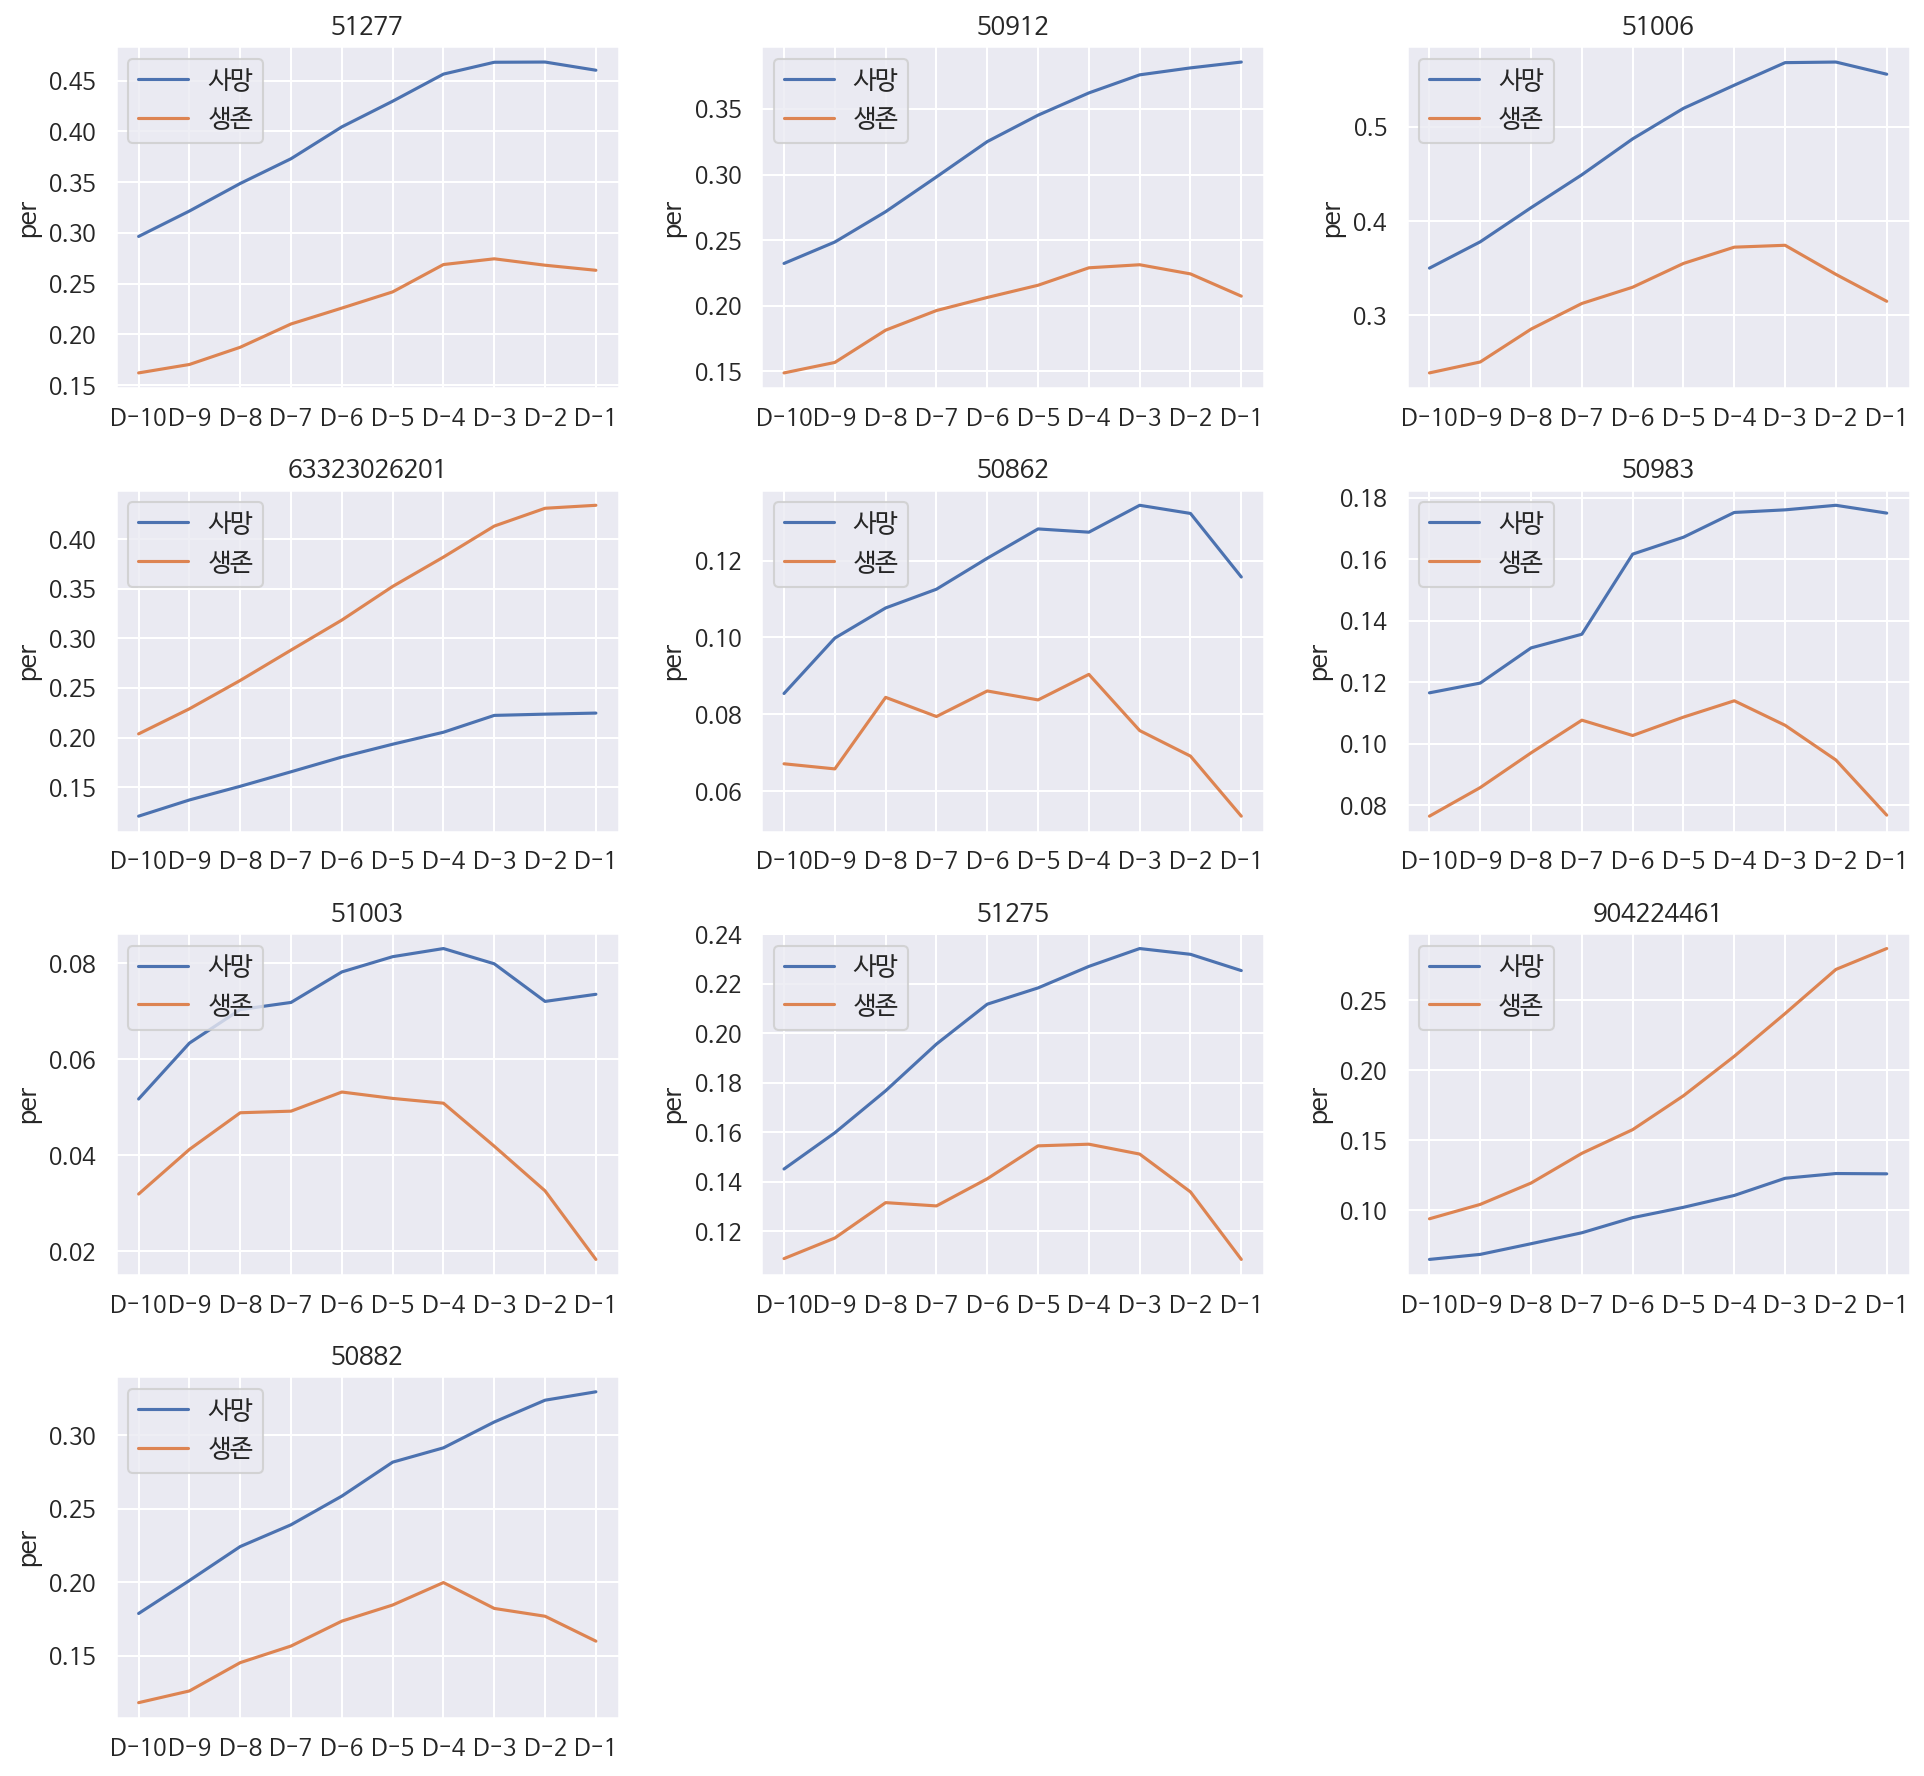

In [22]:
RF_list = list(rf_top10)
absum(RF_list,RF_list[:10])

## (67.3) RF

In [45]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_rf.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6763754045307443, seed_num = 42
정확도 : 0.6692556634304208, seed_num = 43
정확도 : 0.6550161812297735, seed_num = 44
정확도 : 0.6653721682847896, seed_num = 45
정확도 : 0.6899676375404531, seed_num = 46
정확도 : 0.6673139158576051, seed_num = 47
정확도 : 0.6957928802588996, seed_num = 48
정확도 : 0.6802588996763754, seed_num = 49
정확도 : 0.658252427184466, seed_num = 50
정확도 : 0.6724919093851133, seed_num = 51
정확도 df 만들고 평균 확인 : [0.67300971]


## (72.0) LSTM

In [65]:
# rf_top10만을 가진 x_(7727,10,10)_rf 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

rf_top10_index = []
for i in rf_top10:
    rf_top10_index.append(item_list.index(i))

print('rf_top10의 index : ',rf_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,rf_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_rf.npy',x_3d)

rf_top10의 index :  [206, 121, 56, 20, 103, 3832, 34, 2611, 2195, 119]


(7727, 10, 10)

148506.0

In [67]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_rf.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'rf_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 54ms/step - loss: 0.6758 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66596, saving model to ./model/rf_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6730 - acc: 0.6068 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66596
Epoch 3/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6730 - acc: 0.6085 - val_loss: 0.6632 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66596 to 0.66323, saving model to ./model/rf_top10_seed42-03-0.6632.hdf5
Epoch 4/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6547 - acc: 0.6158 - val_loss: 0.6207 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66323 to 0.62068, saving model to ./model/rf_top10_seed42-04-0.6207.hdf5
Epoch 5/500
37/37 [==============================] - 2s 44ms/step - loss: 0.6056 - acc: 

Epoch 39/500
37/37 [==============================] - 1s 38ms/step - loss: 0.5503 - acc: 0.7204 - val_loss: 0.5570 - val_acc: 0.7038

Epoch 00039: val_loss improved from 0.55857 to 0.55695, saving model to ./model/rf_top10_seed42-39-0.5570.hdf5
Epoch 40/500
37/37 [==============================] - 1s 38ms/step - loss: 0.5485 - acc: 0.7220 - val_loss: 0.5567 - val_acc: 0.7031

Epoch 00040: val_loss improved from 0.55695 to 0.55672, saving model to ./model/rf_top10_seed42-40-0.5567.hdf5
Epoch 41/500
37/37 [==============================] - 1s 37ms/step - loss: 0.5504 - acc: 0.7183 - val_loss: 0.5572 - val_acc: 0.7018

Epoch 00041: val_loss did not improve from 0.55672
Epoch 42/500
37/37 [==============================] - 1s 37ms/step - loss: 0.5464 - acc: 0.7174 - val_loss: 0.5568 - val_acc: 0.6999

Epoch 00042: val_loss did not improve from 0.55672
Epoch 43/500
37/37 [==============================] - 1s 37ms/step - loss: 0.5488 - acc: 0.7213 - val_loss: 0.5577 - val_acc: 0.7031

Epoch 

In [68]:
from keras.models import load_model
best_model = load_model('./model/rf_top10_seed42-64-0.5546.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_rf.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.7165048543689321, seed_num = 0
정확도 :0.7249190938511327, seed_num = 1
정확도 :0.7171521035598706, seed_num = 2
정확도 :0.7242718446601941, seed_num = 3
정확도 :0.7242718446601941, seed_num = 4
정확도 :0.7165048543689321, seed_num = 5
정확도 :0.7190938511326861, seed_num = 6
정확도 :0.7216828478964401, seed_num = 7
정확도 :0.7313915857605178, seed_num = 8
정확도 :0.7216828478964401, seed_num = 9
정확도 :0.7249190938511327, seed_num = 10
정확도 :0.7385113268608414, seed_num = 11
정확도 :0.7365695792880259, seed_num = 12
정확도 :0.7190938511326861, seed_num = 13
정확도 :0.7288025889967638, seed_num = 14
정확도 :0.7190938511326861, seed_num = 15
정확도 :0.7190938511326861, seed_num = 16
정확도 :0.7158576051779936, seed_num = 17
정확도 :0.7268608414239482, seed_num = 18
정확도 :0.7216828478964401, seed_num = 19
정확도 :0.7126213592233009, seed_num = 20
정확도 :0.6996763754045308, seed_num = 21
정확도 :0.7223300970873786, seed_num = 22
정확도 :0.713915857605178, seed_num = 23
정확도 :0.7003236245954693, seed_num = 24
정확도 :0.7307443365695793, seed_num = 

In [69]:
# seed = 42의 정확도 df 만들고 평균 확인 => 72.0
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.720673
dtype: float64

# Method 2 : 상위 10개 feature
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [71]:
m2['abs'] = abs(m2['diff2'])
m2 = m2.sort_values(by='abs', ascending=False)
m2_top10 = m2['feature'].values[:10]
m2_top10

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
          54858516,    74706811,    45006701,      228125, 63323016501])

## (60.9) RF

In [72]:
# m2_top10만을 가진 x_(7727,10)_m2 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m2_top10_index = []
for i in m2_top10:
    m2_top10_index.append(item_list.index(i))

print('m2_top10의 index : ',m2_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m2_top10_index]
x_2d.shape

# np.save('x_(7727,10)_m2.npy',x_2d)

m2_top10의 index :  [2195, 1276, 1081, 982, 2744, 1011, 1306, 845, 392, 3820]


(7727, 10)

In [73]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m2.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6006472491909385, seed_num = 42
정확도 : 0.5844660194174758, seed_num = 43
정확도 : 0.594822006472492, seed_num = 44
정확도 : 0.6148867313915858, seed_num = 45
정확도 : 0.6116504854368932, seed_num = 46
정확도 : 0.626537216828479, seed_num = 47
정확도 : 0.627831715210356, seed_num = 48
정확도 : 0.5980582524271845, seed_num = 49
정확도 : 0.625242718446602, seed_num = 50
정확도 : 0.6122977346278318, seed_num = 51
정확도 df 만들고 평균 확인 : [0.60964401]


## (60.8) LSTM

In [74]:
# m2_top10만을 가진 x_(7727,10,10)_m2 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m2_top10_index = []
for i in m2_top10:
    m2_top10_index.append(item_list.index(i))

print('m2_top10의 index : ',m2_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m2_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_m2.npy',x_3d)

m2_top10의 index :  [2195, 1276, 1081, 982, 2744, 1011, 1306, 845, 392, 3820]


(7727, 10, 10)

5833.0

In [75]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m2.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm2_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 4s 47ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/m2_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66551, saving model to ./model/m2_top10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66551 to 0.66526, saving model to ./model/m2_top10_seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 1s 37ms/step - loss: 0.6706 - acc: 

In [76]:
from keras.models import load_model
best_model = load_model('./model/m2_top10_seed42-46-0.6226.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m2.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6045307443365696, seed_num = 0
정확도 :0.6051779935275081, seed_num = 1
정확도 :0.6110032362459547, seed_num = 2
정확도 :0.602588996763754, seed_num = 3
정확도 :0.6097087378640776, seed_num = 4
정확도 :0.6110032362459547, seed_num = 5
정확도 :0.6110032362459547, seed_num = 6
정확도 :0.5928802588996763, seed_num = 7
정확도 :0.6226537216828479, seed_num = 8
정확도 :0.6129449838187703, seed_num = 9
정확도 :0.5909385113268608, seed_num = 10
정확도 :0.6297734627831715, seed_num = 11
정확도 :0.601294498381877, seed_num = 12
정확도 :0.598705501618123, seed_num = 13
정확도 :0.6071197411003236, seed_num = 14
정확도 :0.6135922330097088, seed_num = 15
정확도 :0.6330097087378641, seed_num = 16
정확도 :0.598705501618123, seed_num = 17
정확도 :0.6045307443365696, seed_num = 18
정확도 :0.596116504854369, seed_num = 19
정확도 :0.6187702265372168, seed_num = 20
정확도 :0.6135922330097088, seed_num = 21
정확도 :0.6, seed_num = 22
정확도 :0.6032362459546926, seed_num = 23
정확도 :0.6032362459546926, seed_num = 24
정확도 :0.6071197411003236, seed_num = 25
정확도 :0.595469255

In [77]:
# seed = 42의 정확도 df 만들고 평균 확인 => 60.8
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.608298
dtype: float64

# Method 1 - LSTM all fit
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [3]:
m1_all = pd.read_csv('method1_df_allfit.csv')
m1_all['abs'] = abs(m1_all['mul'])
m1_all = m1_all.sort_values(by='abs', ascending=False)
m1_top10 = m1_all['feature'].values[:10]
m1_top10

array([  409606211,      227194,     4003822,       50889,   182138167,
          74606211,       51200, 25021011210, 63323016101, 63323038810])

## (65.7) RF

In [7]:
# m1_top10만을 가진 x_(7727,10)_m1_allfit 만들기
total_data = pd.read_csv('total_data_7727.csv')
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_top10_index]
x_2d.shape

# np.save('x_(7727,10)_m1_allfit.npy',x_2d)

m1_top10의 index :  [2195, 383, 469, 37, 1815, 1276, 162, 2860, 3818, 3852]


(7727, 10)

In [8]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1_allfit.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6407766990291263, seed_num = 42
정확도 : 0.6498381877022654, seed_num = 43
정확도 : 0.6472491909385113, seed_num = 44
정확도 : 0.6627831715210356, seed_num = 45
정확도 : 0.6524271844660194, seed_num = 46
정확도 : 0.6634304207119741, seed_num = 47
정확도 : 0.6750809061488673, seed_num = 48
정확도 : 0.6576051779935275, seed_num = 49
정확도 : 0.6731391585760518, seed_num = 50
정확도 : 0.6537216828478964, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65760518]


## (65.4) LSTM

In [9]:
# m1_top10만을 가진 x_(7727,10,10)_m1_allfit 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_index = []
for i in m1_top10:
    m1_top10_index.append(item_list.index(i))

print('m1_top10의 index : ',m1_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_top10_index]
x_3d.shape
x_3d.sum()

np.save('x_(7727,10,10)_m1_allfit.npy',x_3d)

m1_top10의 index :  [2195, 383, 469, 37, 1815, 1276, 162, 2860, 3818, 3852]


(7727, 10, 10)

4419.0

In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1_allfit.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_top10_allfit_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 6s 73ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/m1_top10_allfit_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6732 - acc: 0.6068 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66552, saving model to ./model/m1_top10_allfit_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 66ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66552 to 0.66527, saving model to ./model/m1_top10_allfit_seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 2s 64ms/step -


Epoch 00037: val_loss improved from 0.66382 to 0.66052, saving model to ./model/m1_top10_allfit_seed42-37-0.6605.hdf5
Epoch 38/500
37/37 [==============================] - 2s 66ms/step - loss: 0.6567 - acc: 0.6115 - val_loss: 0.6538 - val_acc: 0.6177

Epoch 00038: val_loss improved from 0.66052 to 0.65376, saving model to ./model/m1_top10_allfit_seed42-38-0.6538.hdf5
Epoch 39/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6487 - acc: 0.6115 - val_loss: 0.6420 - val_acc: 0.6177

Epoch 00039: val_loss improved from 0.65376 to 0.64197, saving model to ./model/m1_top10_allfit_seed42-39-0.6420.hdf5
Epoch 40/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6390 - acc: 0.6115 - val_loss: 0.6373 - val_acc: 0.6177

Epoch 00040: val_loss improved from 0.64197 to 0.63726, saving model to ./model/m1_top10_allfit_seed42-40-0.6373.hdf5
Epoch 41/500
37/37 [==============================] - 2s 65ms/step - loss: 0.6363 - acc: 0.6122 - val_loss: 0.6352 - val_acc:

Restoring model weights from the end of the best epoch.

Epoch 00118: val_loss did not improve from 0.62121
Epoch 00118: early stopping


In [11]:
from keras.models import load_model
best_model = load_model('./model/m1_top10_allfit_seed42-93-0.6212.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1_allfit.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

Using TensorFlow backend.


정확도 :0.6524271844660194, seed_num = 0
정확도 :0.6478964401294498, seed_num = 1
정확도 :0.6504854368932039, seed_num = 2
정확도 :0.6466019417475728, seed_num = 3
정확도 :0.6640776699029126, seed_num = 4
정확도 :0.6511326860841424, seed_num = 5
정확도 :0.6601941747572816, seed_num = 6
정확도 :0.6375404530744336, seed_num = 7
정확도 :0.6666666666666666, seed_num = 8
정확도 :0.6563106796116505, seed_num = 9
정확도 :0.63042071197411, seed_num = 10
정확도 :0.6692556634304208, seed_num = 11
정확도 :0.6530744336569579, seed_num = 12
정확도 :0.6524271844660194, seed_num = 13
정확도 :0.6537216828478964, seed_num = 14
정확도 :0.6711974110032363, seed_num = 15
정확도 :0.6679611650485436, seed_num = 16
정확도 :0.6537216828478964, seed_num = 17
정확도 :0.6485436893203883, seed_num = 18
정확도 :0.6466019417475728, seed_num = 19
정확도 :0.6640776699029126, seed_num = 20
정확도 :0.6647249190938511, seed_num = 21
정확도 :0.6459546925566343, seed_num = 22
정확도 :0.6634304207119741, seed_num = 23
정확도 :0.6537216828478964, seed_num = 24
정확도 :0.6660194174757281, seed_num = 2

In [12]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.65499
dtype: float64

# M1 entropy
- 절대값 취하고 절대값 기준으로 내림차순 후 상위 10개 뽑기

In [17]:
m1_entropy = pd.read_csv('m1_entropy.csv')
m1_entropy['abs'] = abs(m1_entropy['mul'])
m1_entropy = m1_entropy.sort_values(by='abs', ascending=False)
m1_entropy_top10 = m1_entropy['feature'].values[:10]
m1_entropy_top10

array([  409606211,    74606211,    67434504,    54817525, 10019055302,
            227194,    54858516,    74706811,    45006701,     4003822])

## (65.1) RF


In [18]:
# m1_entropy_top10만을 가진 x_(7727,10)_m1_entropy 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_entropy_top10_index = []
for i in m1_entropy_top10:
    m1_entropy_top10_index.append(item_list.index(i))

print('m1_entropy_top10의 index : ',m1_entropy_top10_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_entropy_top10_index]
x_2d.shape

np.save('x_(7727,10)_m1_entropy.npy',x_2d)

m1_entropy_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10)

In [19]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1_entropy.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6355987055016181, seed_num = 42
정확도 : 0.6330097087378641, seed_num = 43
정확도 : 0.6349514563106796, seed_num = 44
정확도 : 0.6576051779935275, seed_num = 45
정확도 : 0.6466019417475728, seed_num = 46
정확도 : 0.6634304207119741, seed_num = 47
정확도 : 0.6750809061488673, seed_num = 48
정확도 : 0.654368932038835, seed_num = 49
정확도 : 0.6640776699029126, seed_num = 50
정확도 : 0.6511326860841424, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65158576]


## (64.9) LSTM

In [20]:
# m1_entropy_top10만을 가진 x_(7727,10,10)_m1 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_top10_entropy_index = []
for i in m1_entropy_top10:
    m1_top10_entropy_index.append(item_list.index(i))

print('m1_entropy_top10의 index : ',m1_top10_entropy_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_top10_entropy_index]
x_3d.shape
x_3d.sum()

np.save('x_(7727,10,10)_m1_entropy.npy',x_3d)

m1_entropy_top10의 index :  [2195, 1276, 1081, 982, 2744, 383, 1011, 1306, 845, 469]


(7727, 10, 10)

6187.0

In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1_entropy.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_entropy_top10_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 5s 71ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66603, saving model to ./model/m1_entropy_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66603
Epoch 3/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66603 to 0.66551, saving model to ./model/m1_entropy_top10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6711 - acc: 0.6100 - val_loss: 0.6653 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66551 to 0.66526, saving model to ./model/m1_entropy_top10_seed42-04-0.6653.hdf5
Epoch 5/500
37/37 [==============================] - 2s 64ms/ste

Epoch 35/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6141 - acc: 0.6311 - val_loss: 0.6219 - val_acc: 0.6210

Epoch 00035: val_loss improved from 0.62377 to 0.62185, saving model to ./model/m1_entropy_top10_seed42-35-0.6219.hdf5
Epoch 36/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6144 - acc: 0.6342 - val_loss: 0.6234 - val_acc: 0.6345

Epoch 00036: val_loss did not improve from 0.62185
Epoch 37/500
37/37 [==============================] - 2s 65ms/step - loss: 0.6133 - acc: 0.6333 - val_loss: 0.6196 - val_acc: 0.6423

Epoch 00037: val_loss improved from 0.62185 to 0.61956, saving model to ./model/m1_entropy_top10_seed42-37-0.6196.hdf5
Epoch 38/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6128 - acc: 0.6430 - val_loss: 0.6188 - val_acc: 0.6423

Epoch 00038: val_loss improved from 0.61956 to 0.61877, saving model to ./model/m1_entropy_top10_seed42-38-0.6188.hdf5
Epoch 39/500
37/37 [==============================] - 2s


Epoch 00075: val_loss did not improve from 0.61211
Epoch 76/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5986 - acc: 0.6540 - val_loss: 0.6150 - val_acc: 0.6533

Epoch 00076: val_loss did not improve from 0.61211
Epoch 77/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5990 - acc: 0.6540 - val_loss: 0.6137 - val_acc: 0.6527

Epoch 00077: val_loss did not improve from 0.61211
Epoch 78/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5985 - acc: 0.6540 - val_loss: 0.6150 - val_acc: 0.6533

Epoch 00078: val_loss did not improve from 0.61211
Epoch 79/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5984 - acc: 0.6540 - val_loss: 0.6144 - val_acc: 0.6533

Epoch 00079: val_loss did not improve from 0.61211
Epoch 80/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5987 - acc: 0.6540 - val_loss: 0.6150 - val_acc: 0.6533

Epoch 00080: val_loss did not improve from 0.61211
Epoch 81/500
37/37 [===

In [22]:
from keras.models import load_model
best_model = load_model('./model/m1_entropy_top10_seed42-84-0.6120.hdf5') 

dic_42={}
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('x_(7727,10,10)_m1_entropy.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = best_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    dic_42[seed]=acc
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6466019417475728, seed_num = 0
정확도 :0.6427184466019418, seed_num = 1
정확도 :0.6498381877022654, seed_num = 2
정확도 :0.6375404530744336, seed_num = 3
정확도 :0.654368932038835, seed_num = 4
정확도 :0.655663430420712, seed_num = 5
정확도 :0.6537216828478964, seed_num = 6
정확도 :0.629126213592233, seed_num = 7
정확도 :0.6614886731391586, seed_num = 8
정확도 :0.6498381877022654, seed_num = 9
정확도 :0.627831715210356, seed_num = 10
정확도 :0.6711974110032363, seed_num = 11
정확도 :0.6472491909385113, seed_num = 12
정확도 :0.6414239482200648, seed_num = 13
정확도 :0.6466019417475728, seed_num = 14
정확도 :0.656957928802589, seed_num = 15
정확도 :0.6692556634304208, seed_num = 16
정확도 :0.6453074433656958, seed_num = 17
정확도 :0.6459546925566343, seed_num = 18
정확도 :0.6414239482200648, seed_num = 19
정확도 :0.6601941747572816, seed_num = 20
정확도 :0.6595469255663431, seed_num = 21
정확도 :0.6375404530744336, seed_num = 22
정확도 :0.6550161812297735, seed_num = 23
정확도 :0.6530744336569579, seed_num = 24
정확도 :0.6491909385113268, seed_num = 25
정

In [23]:
# seed = 42의 정확도 df 만들고 평균 확인 => 64.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.649204
dtype: float64

# M2_df_원시간*근시간

In [7]:
total_data = pd.read_csv('total_data_7727.csv')
m2_변동성 = pd.read_csv('method2_df_원시간*근시간.csv')
m2_변동성_feature = m2_변동성['feature'].tolist()

# LAB, PRE, PRO의 item_list 생성 
LAB_item = total_data[total_data['TYPE']=='LAB']['ITEMID'].sort_values().unique()
PRE_item = total_data[total_data['TYPE']=='PRE']['ITEMID'].sort_values().unique()
PRO_item = total_data[total_data['TYPE']=='PRO']['ITEMID'].sort_values().unique()

LAB_list = []
PRE_list = []
PRO_list = []
for i in m2_변동성_feature:
    if i in LAB_item:
        LAB_list.append(i)
    elif i in PRE_item:
        PRE_list.append(i)
    else:
        PRO_list.append(i)

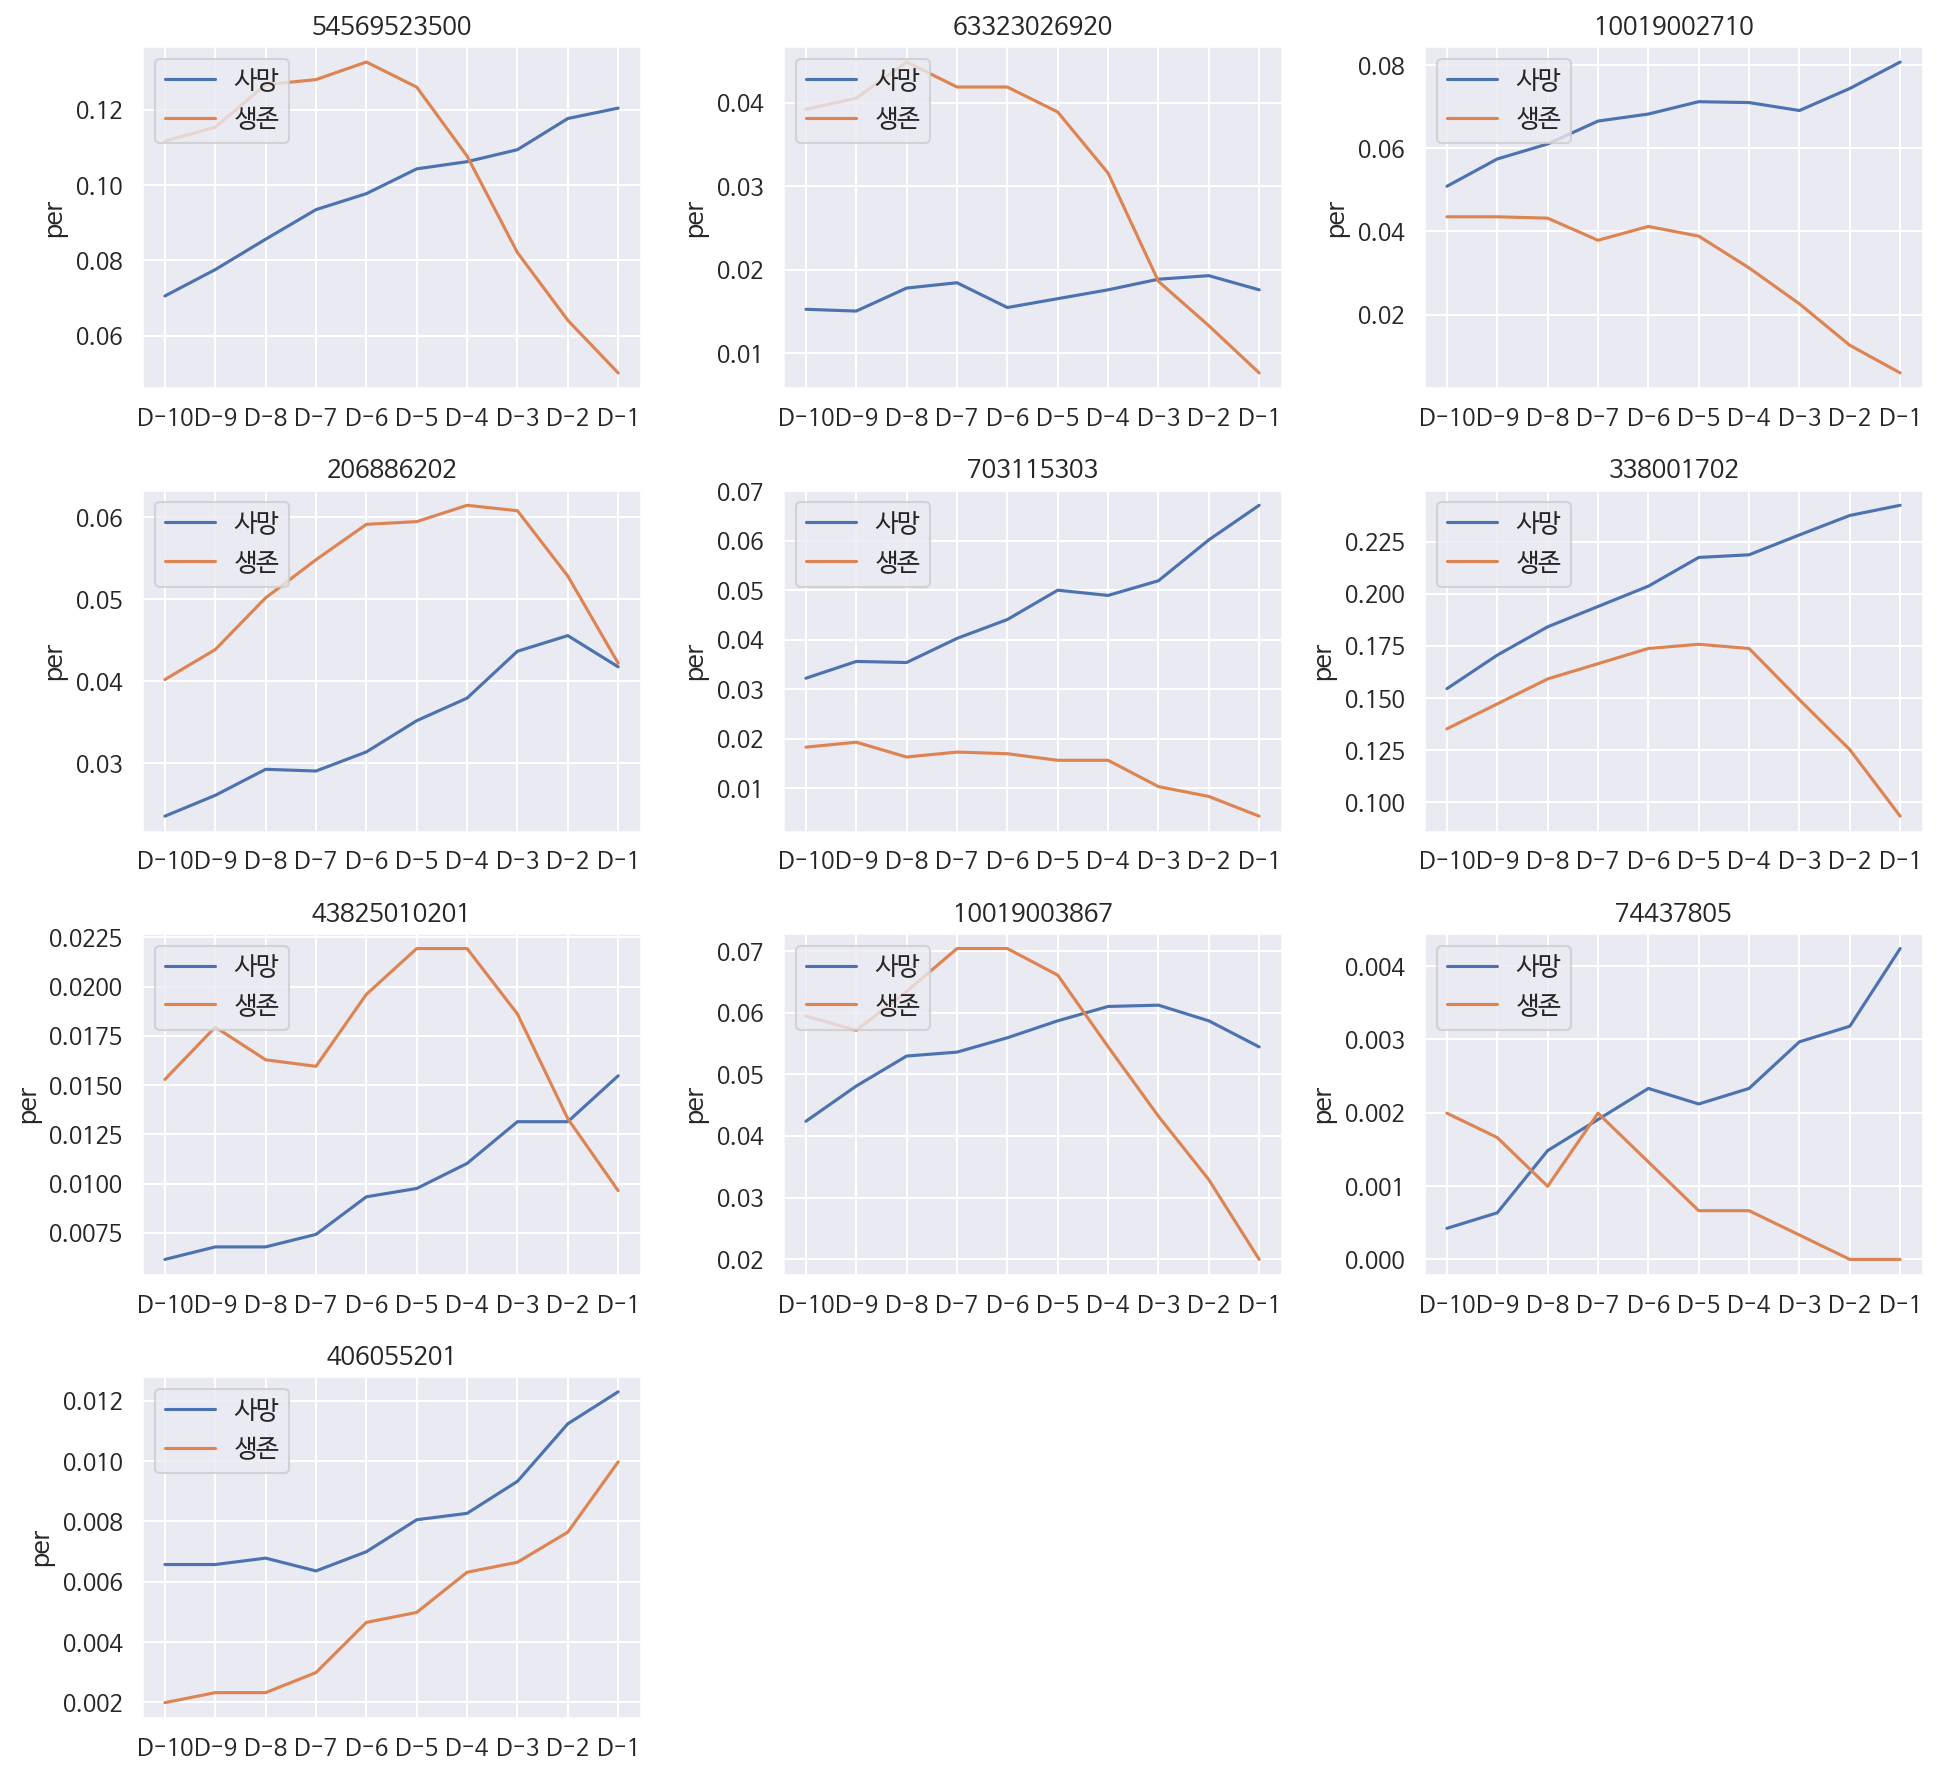

In [9]:
absum(PRE_list,PRE_list[:10])

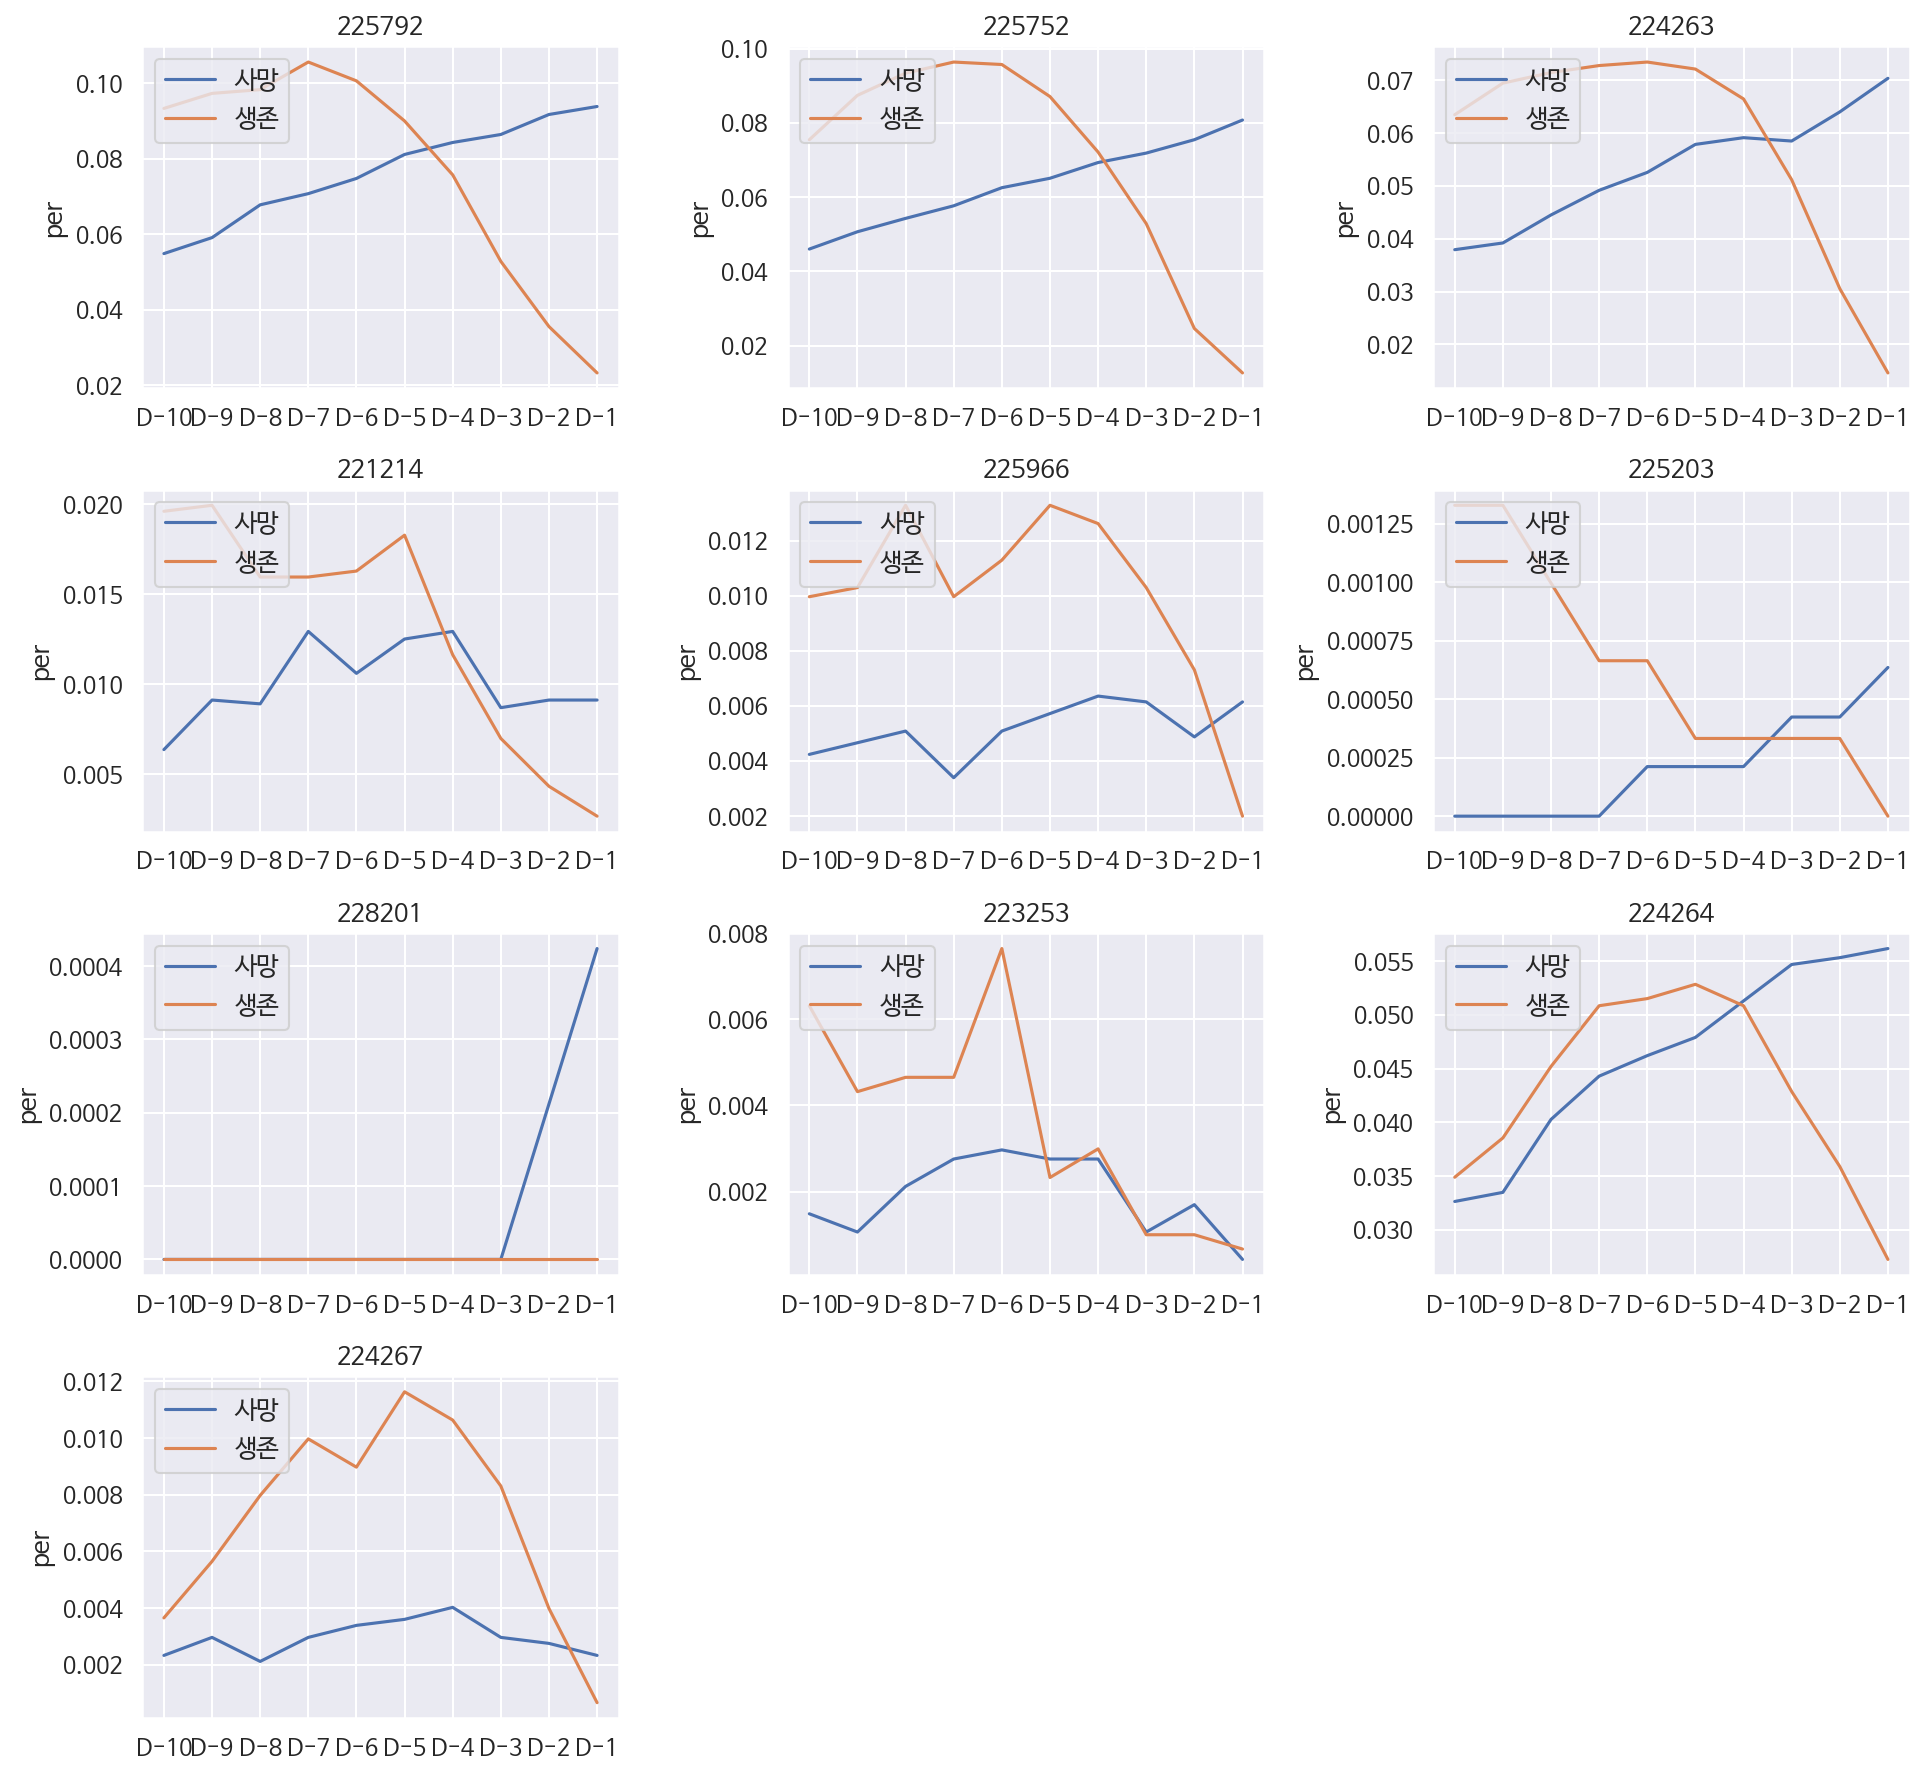

In [10]:
absum(PRO_list,PRO_list[:10])

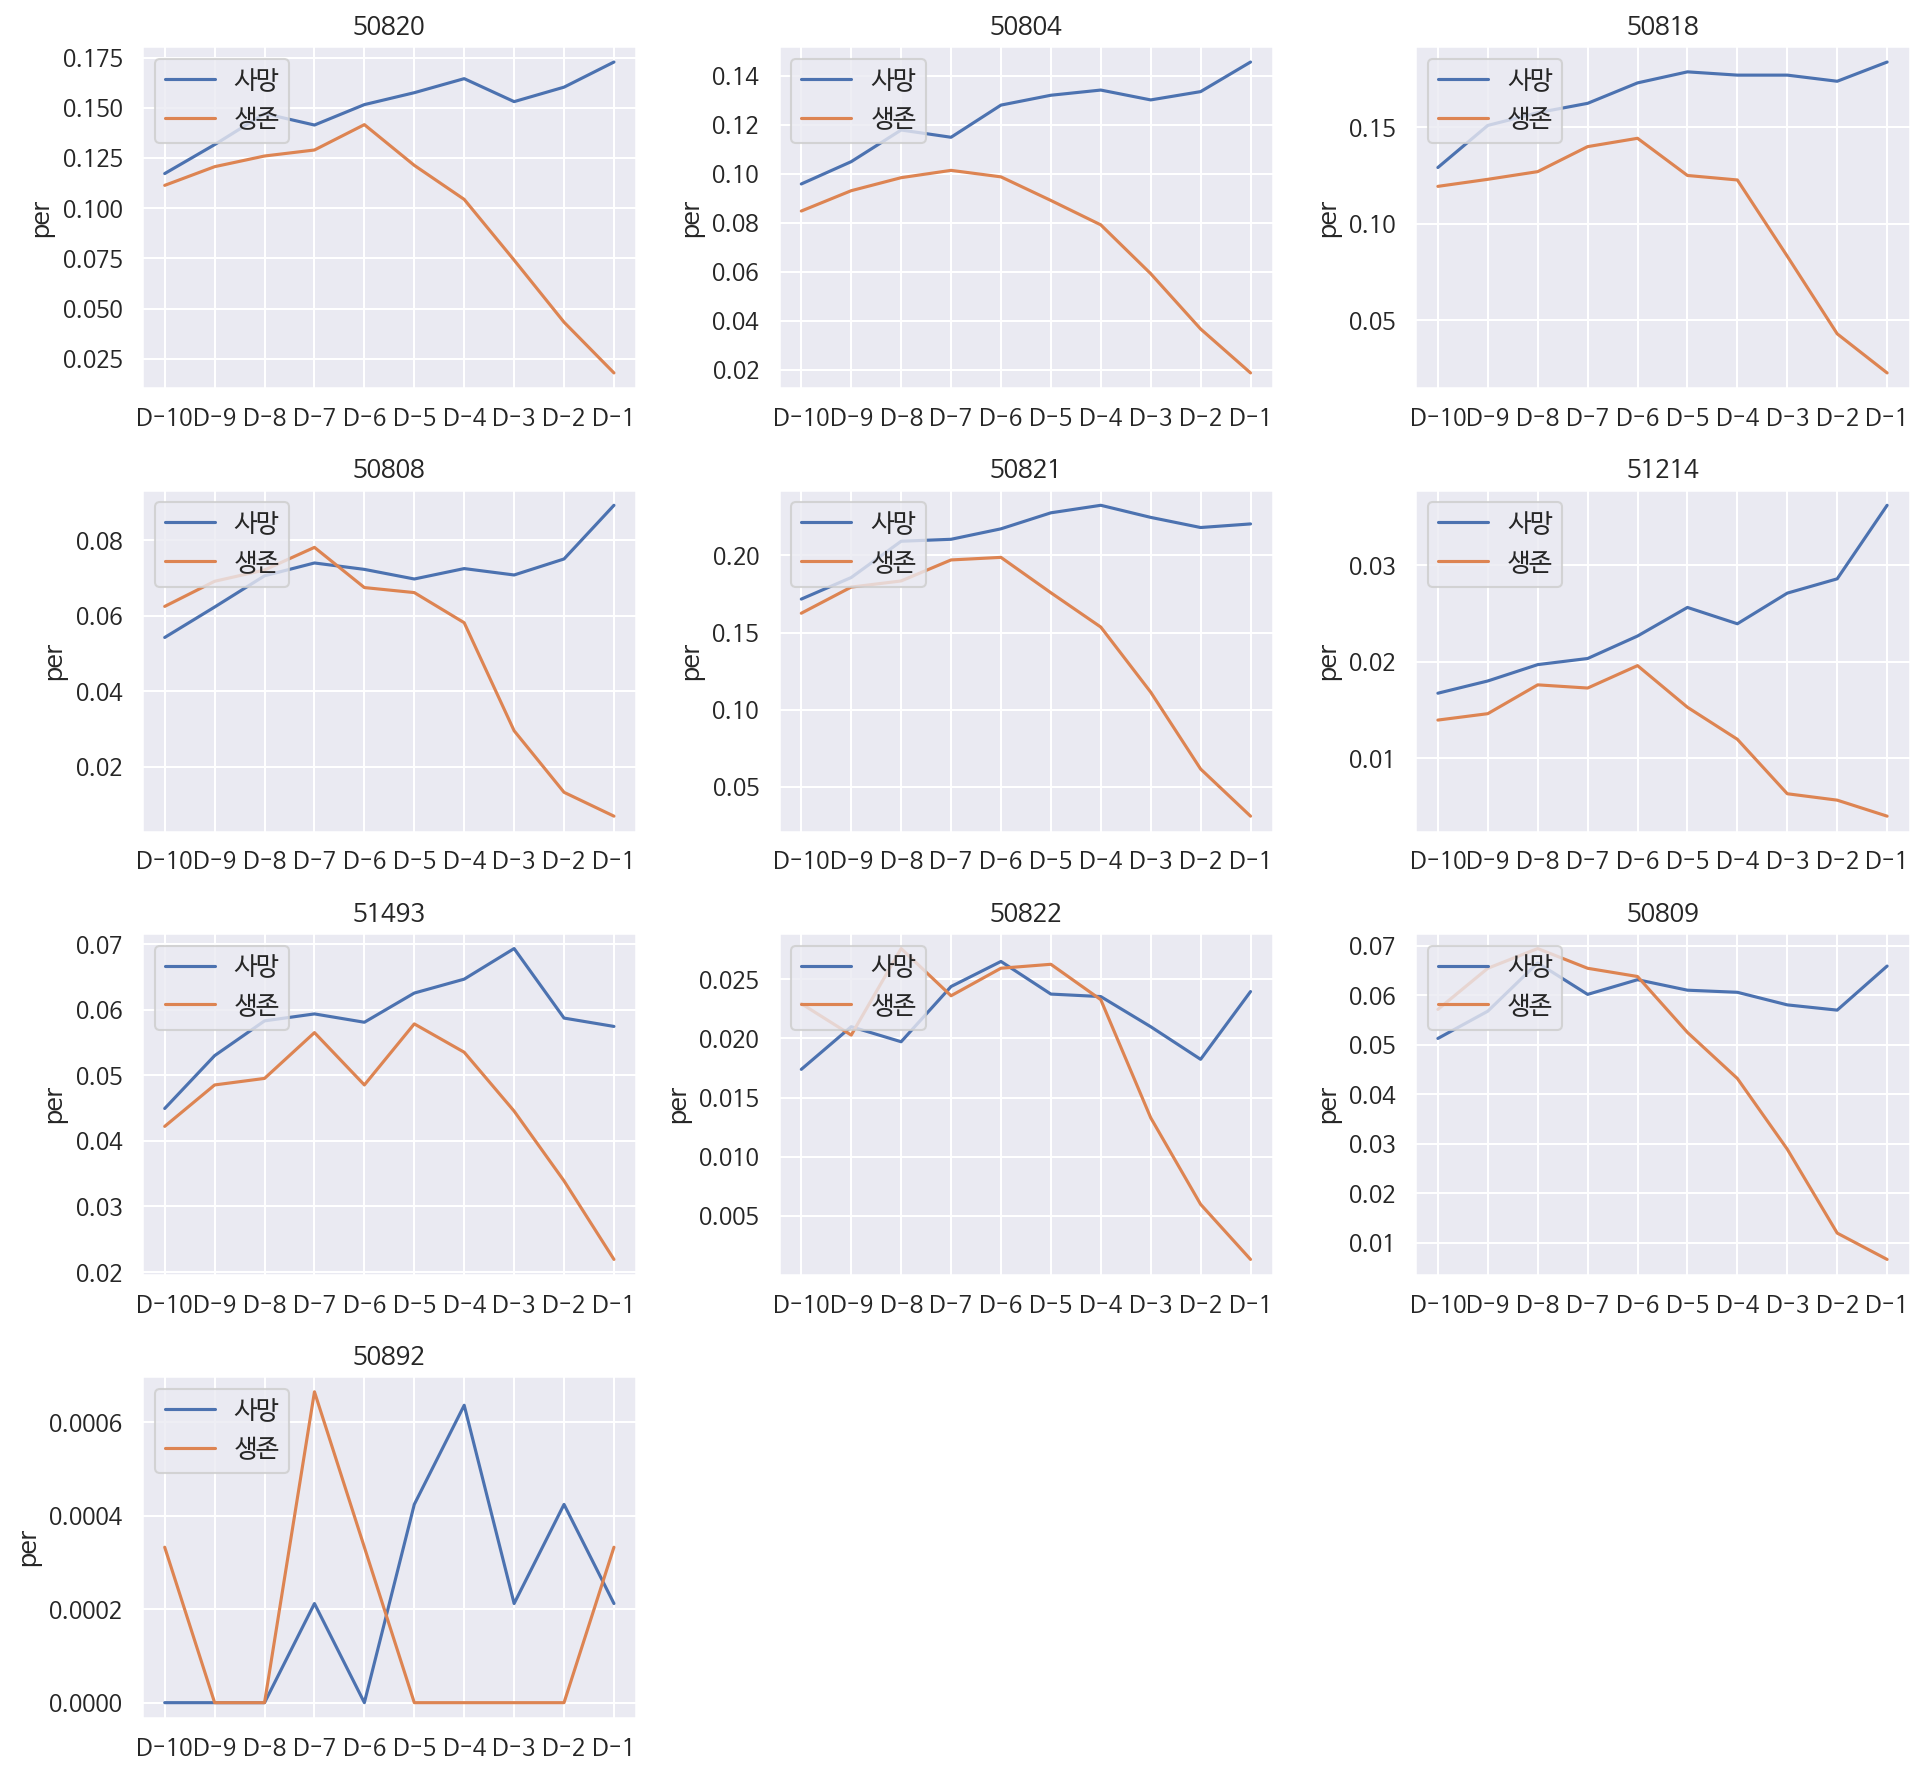

In [11]:
absum(LAB_list,LAB_list[:10])

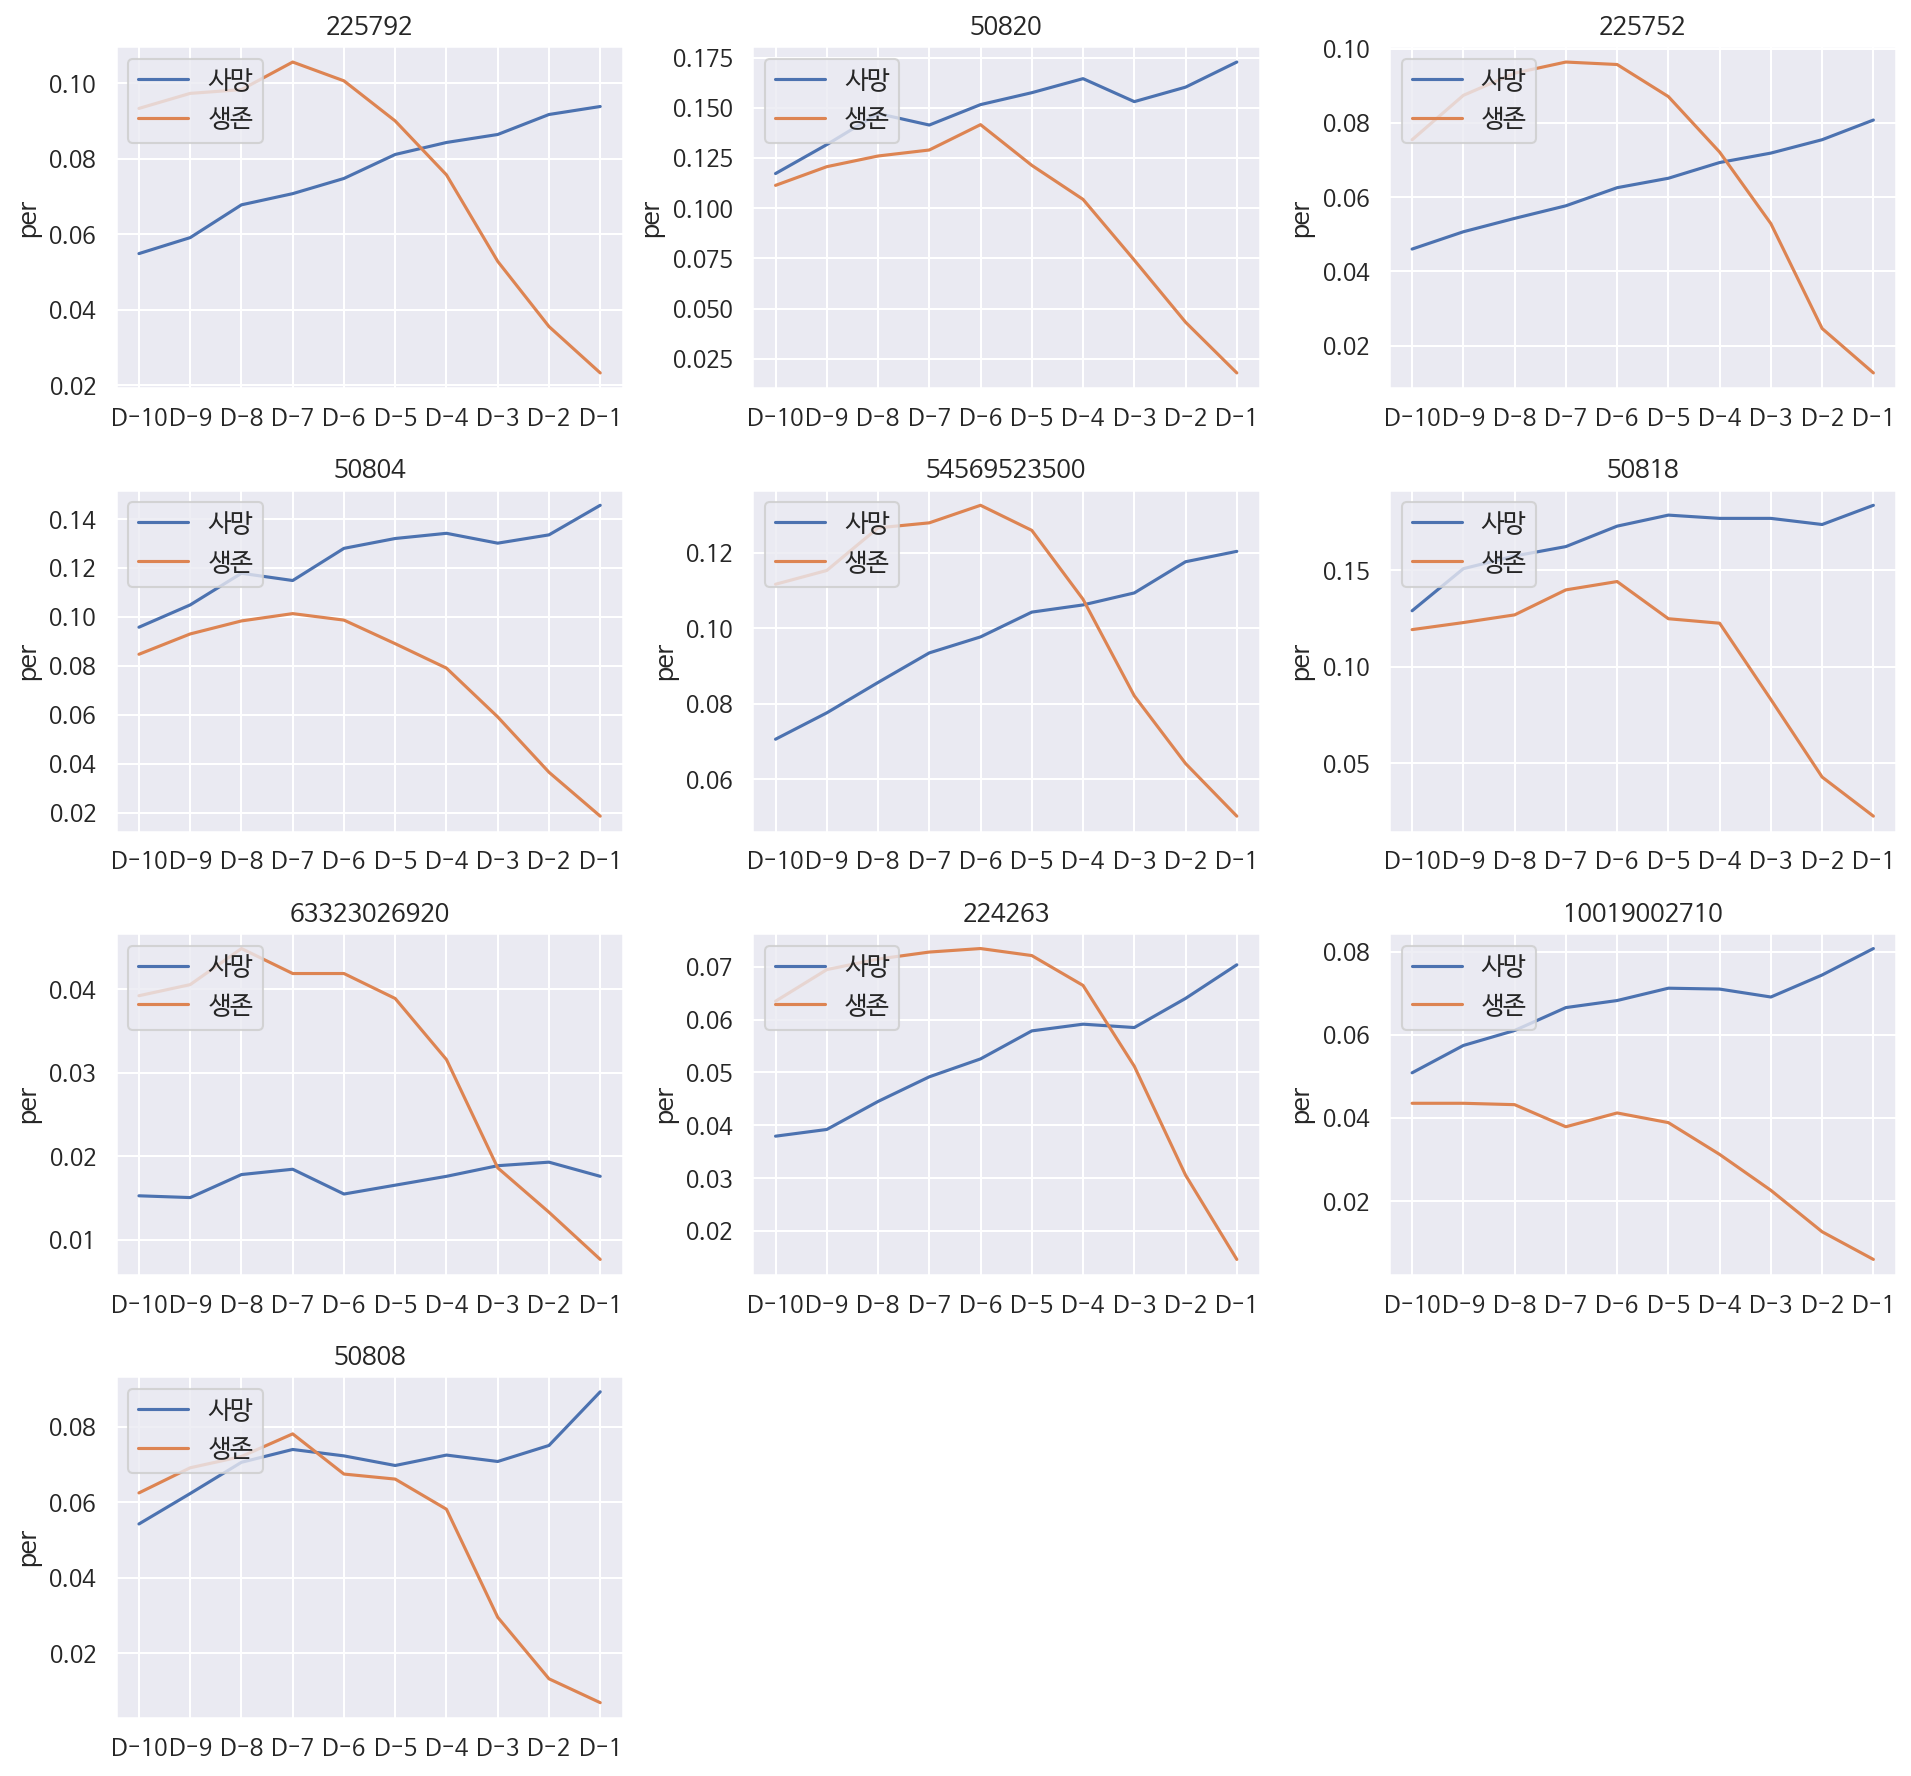

In [12]:
absum(m2_변동성_feature,m2_변동성_feature[:10])

# E(0to1) - E(1to0)
- 22.02.22 Tue

In [4]:
mm = pd.read_csv('FI_mean_merge.csv')
mm['E(0to1)-E(1to0)'] = mm['pred_0to1']-mm['pred_1to0']
mm_top10 = mm.sort_values(by='E(0to1)-E(1to0)',ascending=False)['feature'].values[:10]
mm_top10

array([  409606211,    74606211,    67434504, 10019055302,    54817525,
             51277,    54858516,    45006701,    74706811,       51003])

## (67.1) RF

In [30]:
# mean_diff_top10만을 가진 x_(7727,10)_mean_diff 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

mmlist_index = []
for i in mm_top10:
    mmlist_index.append(item_list.index(i))

print('mean_diff_top10의 index : ',mmlist_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,mmlist_index]
x_2d.shape

# np.save('x_(7727,10)_mean_diff',x_2d)

mean_diff_top10의 index :  [2195, 1276, 1081, 2744, 982, 206, 1011, 845, 1306, 119]


(7727, 10)

In [28]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_mean_diff.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6576051779935275, seed_num = 42
정확도 : 0.6621359223300971, seed_num = 43
정확도 : 0.6517799352750809, seed_num = 44
정확도 : 0.6711974110032363, seed_num = 45
정확도 : 0.6776699029126214, seed_num = 46
정확도 : 0.6944983818770226, seed_num = 47
정확도 : 0.6977346278317152, seed_num = 48
정확도 : 0.6608414239482201, seed_num = 49
정확도 : 0.6653721682847896, seed_num = 50
정확도 : 0.6770226537216828, seed_num = 51
정확도 df 만들고 평균 확인 : [0.67158576]


## (67.9) LSTM

In [5]:
# mm_top10만을 가진 x_(7727,10,10)_mean_diff 만들기
total_data = pd.read_csv('total_data_7727.csv')
item_list = list(total_data['ITEMID'].sort_values().unique())

mm_top10_index = []
for i in mm_top10:
    mm_top10_index.append(item_list.index(i))

print('mm_top10의 index : ',mm_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,mm_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_mean_diff.npy',x_3d)

mm_top10의 index :  [2195, 1276, 1081, 2744, 982, 206, 1011, 845, 1306, 119]


(7727, 10, 10)

35507.0

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_mean_diff.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'mean_diff_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 6s 74ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66602, saving model to ./model/mean_diff_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 60ms/step - loss: 0.6732 - acc: 0.6068 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66602
Epoch 3/500
37/37 [==============================] - 2s 61ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66602 to 0.66549, saving model to ./model/mean_diff_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 59ms/step - loss: 0.6710 - acc: 0.6100 - val_loss: 0.6652 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66549 to 0.66520, saving model to ./model/mean_diff_seed42-04-0.6652.hdf5
Epoch 5/500
37/37 [==============================] - 2s 61ms/step - loss: 0.6705 - ac

37/37 [==============================] - 2s 61ms/step - loss: 0.5795 - acc: 0.6872 - val_loss: 0.5985 - val_acc: 0.6643

Epoch 00036: val_loss did not improve from 0.59601
Epoch 37/500
37/37 [==============================] - 2s 61ms/step - loss: 0.5764 - acc: 0.6881 - val_loss: 0.5976 - val_acc: 0.6656

Epoch 00037: val_loss did not improve from 0.59601
Epoch 38/500
37/37 [==============================] - 2s 60ms/step - loss: 0.5780 - acc: 0.6855 - val_loss: 0.5963 - val_acc: 0.6656

Epoch 00038: val_loss did not improve from 0.59601
Epoch 39/500
37/37 [==============================] - 2s 61ms/step - loss: 0.5766 - acc: 0.6829 - val_loss: 0.5981 - val_acc: 0.6649

Epoch 00039: val_loss did not improve from 0.59601
Epoch 40/500
37/37 [==============================] - 2s 61ms/step - loss: 0.5750 - acc: 0.6866 - val_loss: 0.5976 - val_acc: 0.6643

Epoch 00040: val_loss did not improve from 0.59601
Epoch 41/500
37/37 [==============================] - 2s 61ms/step - loss: 0.5771 - acc:

In [6]:
import random
from sklearn import metrics 

with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

    from keras.models import load_model
    best_model = load_model('./model/mean_diff_seed42-20-0.5960.hdf5') 

    dic_42={}
    for seed in range(0, 50):
        random.seed(seed)

        x = np.load('x_(7727,10,10)_mean_diff.npy')
        y = np.load('y_(7727,1).npy')

        idx = list(range(len(x)))
        random.shuffle(idx)

        i = round(x.shape[0]*0.8)
        X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
        X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

        pred = best_model.predict(X_test)
        pred[pred>0.5]=1
        pred[pred<=0.5]=0
        acc = metrics.accuracy_score(y_test, pred)
        dic_42[seed]=acc
        print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.6737864077669903, seed_num = 0
정확도 :0.6750809061488673, seed_num = 1
정확도 :0.6893203883495146, seed_num = 2
정확도 :0.7009708737864078, seed_num = 3
정확도 :0.6822006472491909, seed_num = 4
정확도 :0.6880258899676376, seed_num = 5
정확도 :0.686084142394822, seed_num = 6
정확도 :0.683495145631068, seed_num = 7
정확도 :0.6783171521035599, seed_num = 8
정확도 :0.6731391585760518, seed_num = 9
정확도 :0.6796116504854369, seed_num = 10
정확도 :0.6796116504854369, seed_num = 11
정확도 :0.686084142394822, seed_num = 12
정확도 :0.6744336569579288, seed_num = 13
정확도 :0.6854368932038835, seed_num = 14
정확도 :0.6783171521035599, seed_num = 15
정확도 :0.6653721682847896, seed_num = 16
정확도 :0.6718446601941748, seed_num = 17
정확도 :0.6711974110032363, seed_num = 18
정확도 :0.6886731391585761, seed_num = 19
정확도 :0.6796116504854369, seed_num = 20
정확도 :0.6686084142394823, seed_num = 21
정확도 :0.6737864077669903, seed_num = 22
정확도 :0.6640776699029126, seed_num = 23
정확도 :0.6621359223300971, seed_num = 24
정확도 :0.6796116504854369, seed_num = 25

In [7]:
# seed = 42의 정확도 df 만들고 평균 확인 => 67.9
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
df_42.mean()

0    0.679262
dtype: float64

## absum 그래프

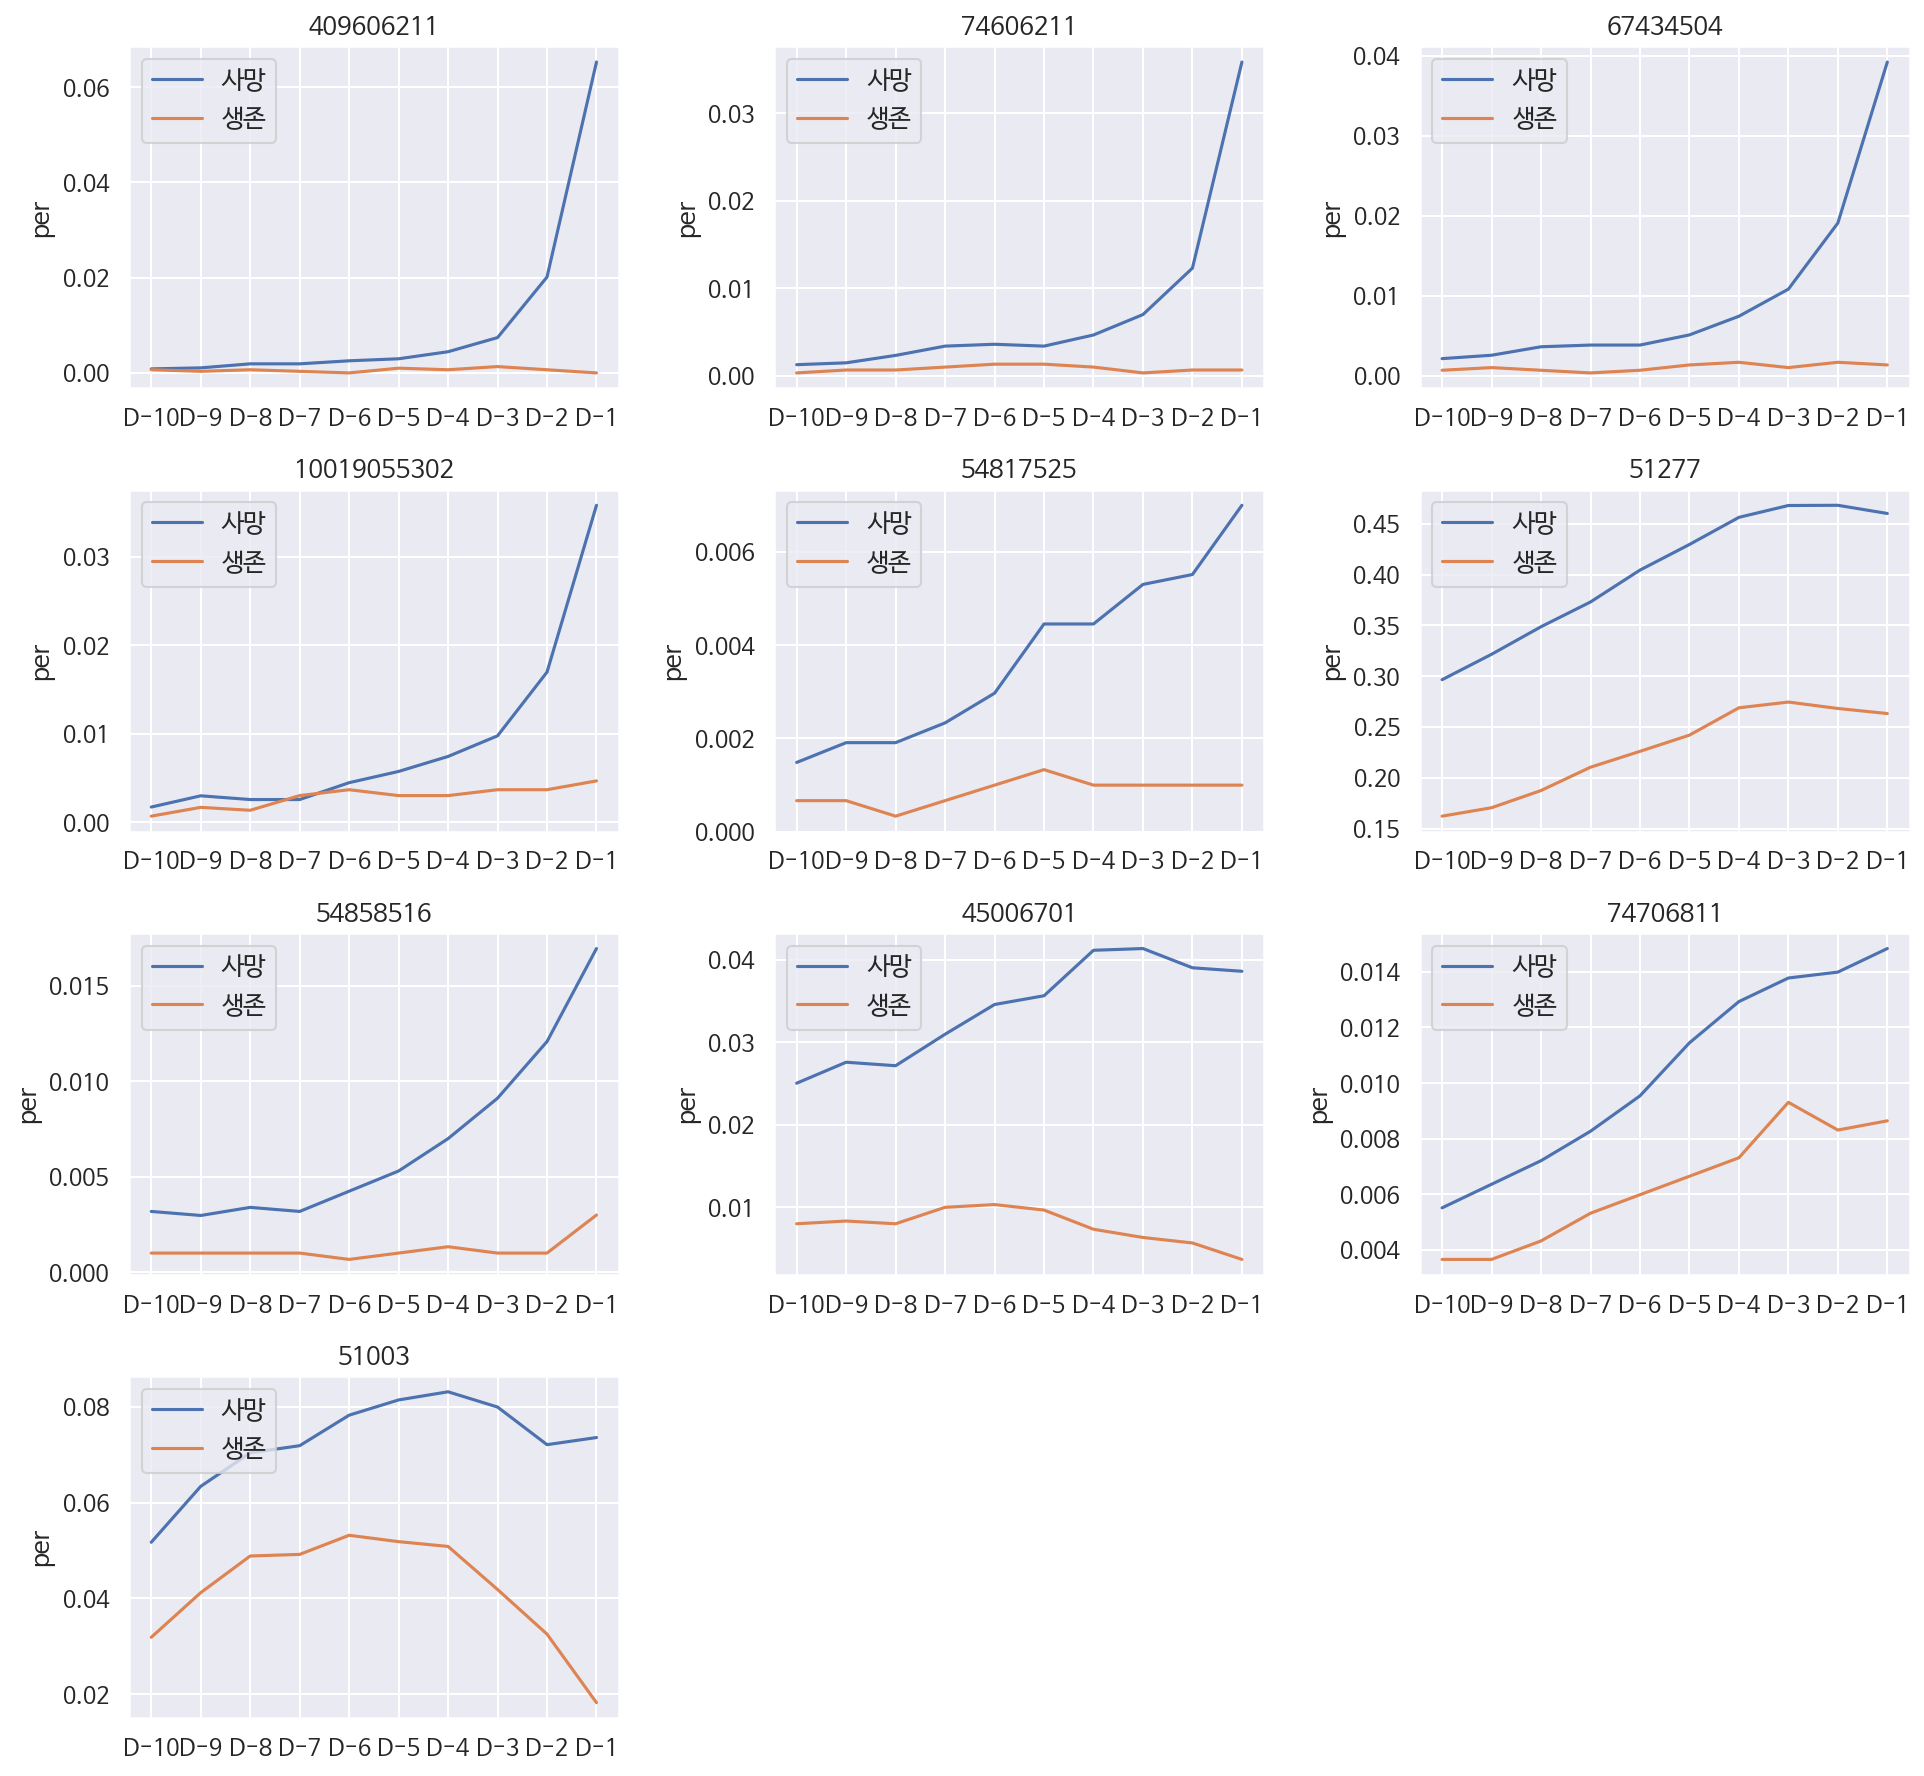

In [5]:
mm_list = [409606211, 74606211, 67434504, 10019055302, 54817525,
           51277, 54858516, 45006701, 74706811, 51003]
absum(mm_list,mm_list[:10])

# M1_new_top10
- 22.02.22 Tue

In [23]:
m1_new = pd.read_csv('m1_new.csv')
m1_new_top10 = m1_new['feature'].values[:10]
m1_new_top10

array([    51277,     51006,     50912,     50882, 409176230,     50862,
           51003,     50983,     50893, 487980125])

## (65.6) RF

In [9]:
# m1_new만을 가진 x_(7727,10)_m1_new 만들기
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_new_index = []
for i in m1_new_top10:
    m1_new_index.append(item_list.index(i))

print('m1_new_top10의 index : ',m1_new_index)

x = np.load('x_(7727,4068).npy')
x_2d = x[:,m1_new_index]
x_2d.shape

# np.save('x_(7727,10)_m1_new',x_2d)

m1_new_top10의 index :  [206, 121, 56, 34, 2148, 20, 119, 103, 41, 2291]


(7727, 10)

In [10]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

data={}
for seed in range(42, 52):
    random.seed(seed)
    
    x = np.load('./x_(7727,10)_m1_new.npy')
    y = np.load('./y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:], y[idx[i:]]
    
    _ = model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_test)
    data[seed]=acc
    print(f'정확도 : {acc}, seed_num = {seed}')

df = pd.DataFrame.from_dict(data, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')

정확도 : 0.6524271844660194, seed_num = 42
정확도 : 0.6550161812297735, seed_num = 43
정확도 : 0.6381877022653721, seed_num = 44
정확도 : 0.6433656957928803, seed_num = 45
정확도 : 0.6588996763754046, seed_num = 46
정확도 : 0.6653721682847896, seed_num = 47
정확도 : 0.6815533980582524, seed_num = 48
정확도 : 0.6524271844660194, seed_num = 49
정확도 : 0.6608414239482201, seed_num = 50
정확도 : 0.6537216828478964, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65618123]


## (70.3) LSTM

In [11]:
# m1_new_top10만을 가진 x_(7727,10,10)_m1_new 만들기
total_data = pd.read_csv('total_data_7727.csv')
item_list = list(total_data['ITEMID'].sort_values().unique())

m1_new_top10_index = []
for i in m1_new_top10:
    m1_new_top10_index.append(item_list.index(i))

print('m1_new_top10의 index : ',m1_new_top10_index)

x = np.load('x_(7727,10,4068).npy')
x_3d = x[:,:,m1_new_top10_index]
x_3d.shape
x_3d.sum()

# np.save('x_(7727,10,10)_m1_new.npy',x_3d)

m1_new_top10의 index :  [206, 121, 56, 34, 2148, 20, 119, 103, 41, 2291]


(7727, 10, 10)

160495.0

In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random
# ----------------------
seed_num = 42
# ----------------------
random.seed(seed_num)

x = np.load('x_(7727,10,10)_m1_new.npy')
y = np.load('y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# ---------------------
seed_num = 42 
# ---------------------
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

from tensorflow.keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + 'm1_new_seed42-{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)

Epoch 1/500
37/37 [==============================] - 6s 71ms/step - loss: 0.6758 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66597, saving model to ./model/m1_new_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6731 - acc: 0.6068 - val_loss: 0.6661 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66597
Epoch 3/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6734 - acc: 0.6083 - val_loss: 0.6646 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66597 to 0.66464, saving model to ./model/m1_new_seed42-03-0.6646.hdf5
Epoch 4/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6646 - acc: 0.6117 - val_loss: 0.6475 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66464 to 0.64750, saving model to ./model/m1_new_seed42-04-0.6475.hdf5
Epoch 5/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6422 - acc: 0.6111

37/37 [==============================] - 2s 63ms/step - loss: 0.5776 - acc: 0.7034 - val_loss: 0.5859 - val_acc: 0.6772

Epoch 00033: val_loss improved from 0.58601 to 0.58595, saving model to ./model/m1_new_seed42-33-0.5859.hdf5
Epoch 34/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5754 - acc: 0.7028 - val_loss: 0.5865 - val_acc: 0.6811

Epoch 00034: val_loss did not improve from 0.58595
Epoch 35/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5769 - acc: 0.7034 - val_loss: 0.5871 - val_acc: 0.6818

Epoch 00035: val_loss did not improve from 0.58595
Epoch 36/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5779 - acc: 0.7002 - val_loss: 0.5852 - val_acc: 0.6785

Epoch 00036: val_loss improved from 0.58595 to 0.58517, saving model to ./model/m1_new_seed42-36-0.5852.hdf5
Epoch 37/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5743 - acc: 0.7019 - val_loss: 0.5848 - val_acc: 0.6785

Epoch 00037: val_loss i

37/37 [==============================] - 2s 63ms/step - loss: 0.5634 - acc: 0.7133 - val_loss: 0.5822 - val_acc: 0.6915

Epoch 00074: val_loss did not improve from 0.58159
Epoch 75/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5624 - acc: 0.7084 - val_loss: 0.5825 - val_acc: 0.6915

Epoch 00075: val_loss did not improve from 0.58159
Epoch 76/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5626 - acc: 0.7116 - val_loss: 0.5813 - val_acc: 0.6895

Epoch 00076: val_loss improved from 0.58159 to 0.58134, saving model to ./model/m1_new_seed42-76-0.5813.hdf5
Epoch 77/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5591 - acc: 0.7131 - val_loss: 0.5827 - val_acc: 0.6921

Epoch 00077: val_loss did not improve from 0.58134
Epoch 78/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5619 - acc: 0.7105 - val_loss: 0.5821 - val_acc: 0.6889

Epoch 00078: val_loss did not improve from 0.58134
Epoch 79/500
37/37 [==========

37/37 [==============================] - 2s 61ms/step - loss: 0.5485 - acc: 0.7233 - val_loss: 0.5849 - val_acc: 0.6908

Epoch 00117: val_loss did not improve from 0.58063
Epoch 118/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5479 - acc: 0.7207 - val_loss: 0.5830 - val_acc: 0.6934

Epoch 00118: val_loss did not improve from 0.58063
Epoch 119/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5482 - acc: 0.7192 - val_loss: 0.5840 - val_acc: 0.6934

Epoch 00119: val_loss did not improve from 0.58063
Epoch 120/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5486 - acc: 0.7233 - val_loss: 0.5824 - val_acc: 0.6966

Epoch 00120: val_loss did not improve from 0.58063
Epoch 121/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5477 - acc: 0.7256 - val_loss: 0.5832 - val_acc: 0.6915

Epoch 00121: val_loss did not improve from 0.58063
Epoch 122/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5479 -

37/37 [==============================] - 2s 64ms/step - loss: 0.5339 - acc: 0.7304 - val_loss: 0.6010 - val_acc: 0.6921

Epoch 00161: val_loss did not improve from 0.58063
Epoch 162/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5327 - acc: 0.7286 - val_loss: 0.5973 - val_acc: 0.6915

Epoch 00162: val_loss did not improve from 0.58063
Epoch 163/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5334 - acc: 0.7263 - val_loss: 0.6013 - val_acc: 0.6921

Epoch 00163: val_loss did not improve from 0.58063
Epoch 164/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5319 - acc: 0.7269 - val_loss: 0.6014 - val_acc: 0.6928

Epoch 00164: val_loss did not improve from 0.58063
Epoch 165/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5325 - acc: 0.7252 - val_loss: 0.6031 - val_acc: 0.6908

Epoch 00165: val_loss did not improve from 0.58063
Epoch 166/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5328 -

37/37 [==============================] - 2s 63ms/step - loss: 0.5145 - acc: 0.7399 - val_loss: 0.6020 - val_acc: 0.6895

Epoch 00205: val_loss did not improve from 0.58063
Epoch 206/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5137 - acc: 0.7399 - val_loss: 0.6050 - val_acc: 0.6915

Epoch 00206: val_loss did not improve from 0.58063
Epoch 207/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5127 - acc: 0.7390 - val_loss: 0.6070 - val_acc: 0.6908

Epoch 00207: val_loss did not improve from 0.58063
Epoch 208/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5126 - acc: 0.7407 - val_loss: 0.6095 - val_acc: 0.6934

Epoch 00208: val_loss did not improve from 0.58063
Epoch 209/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5129 - acc: 0.7403 - val_loss: 0.6072 - val_acc: 0.6940

Epoch 00209: val_loss did not improve from 0.58063
Epoch 210/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5103 -

In [13]:
import random
from sklearn import metrics 

with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

    from keras.models import load_model
    best_model = load_model('./model/m1_new_seed42-87-0.5806.hdf5') 

    dic_42={}
    for seed in range(0, 50):
        random.seed(seed)

        x = np.load('x_(7727,10,10)_m1_new.npy')
        y = np.load('y_(7727,1).npy')

        idx = list(range(len(x)))
        random.shuffle(idx)

        i = round(x.shape[0]*0.8)
        X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
        X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

        pred = best_model.predict(X_test)
        pred[pred>0.5]=1
        pred[pred<=0.5]=0
        acc = metrics.accuracy_score(y_test, pred)
        dic_42[seed]=acc
        print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')
        
df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
print(f'정확도 df 만들고 평균 확인 : {df_42.mean().values}')

Using TensorFlow backend.


정확도 :0.7022653721682848, seed_num = 0
정확도 :0.7029126213592233, seed_num = 1
정확도 :0.6983818770226538, seed_num = 2
정확도 :0.7067961165048544, seed_num = 3
정확도 :0.7042071197411003, seed_num = 4
정확도 :0.7022653721682848, seed_num = 5
정확도 :0.6919093851132686, seed_num = 6
정확도 :0.6983818770226538, seed_num = 7
정확도 :0.7113268608414239, seed_num = 8
정확도 :0.6990291262135923, seed_num = 9
정확도 :0.7055016181229773, seed_num = 10
정확도 :0.7016181229773463, seed_num = 11
정확도 :0.7132686084142394, seed_num = 12
정확도 :0.7016181229773463, seed_num = 13
정확도 :0.7048543689320388, seed_num = 14
정확도 :0.7003236245954693, seed_num = 15
정확도 :0.7113268608414239, seed_num = 16
정확도 :0.7035598705501618, seed_num = 17
정확도 :0.713915857605178, seed_num = 18
정확도 :0.7048543689320388, seed_num = 19
정확도 :0.7016181229773463, seed_num = 20
정확도 :0.6854368932038835, seed_num = 21
정확도 :0.6970873786407767, seed_num = 22
정확도 :0.6880258899676376, seed_num = 23
정확도 :0.6893203883495146, seed_num = 24
정확도 :0.7177993527508091, seed_num = 

# M1_new_bottom10

In [38]:
m1_new = pd.read_csv('m1_new.csv')
m1_new_bottom10 = m1_new['feature'].values[-10:]
m1_new_bottom10

array([  409672924, 55390000401,      224277,     8084199,       51221,
             51237,       50861,       51249,           0, 63323026201])

## (63.6) RF

In [54]:
RF_정확도(m1_new_bottom10,'m1_new_bottom10')

itemlist의 index :  [2212, 3456, 307, 619, 174, 182, 19, 187, 0, 3832]
정확도 : 0.6161812297734628, seed_num = 42
정확도 : 0.6297734627831715, seed_num = 43
정확도 : 0.6148867313915858, seed_num = 44
정확도 : 0.6530744336569579, seed_num = 45
정확도 : 0.6440129449838188, seed_num = 46
정확도 : 0.655663430420712, seed_num = 47
정확도 : 0.6530744336569579, seed_num = 48
정확도 : 0.6207119741100323, seed_num = 49
정확도 : 0.6511326860841424, seed_num = 50
정확도 : 0.6258899676375405, seed_num = 51
정확도 df 만들고 평균 확인 : [0.63644013]


## (67.1) LSTM

In [68]:
LSTM_정확도(m1_new_bottom10,'m1_new_bottom10')

itemlist의 index :  [2212, 3456, 307, 619, 174, 182, 19, 187, 0, 3832]
Epoch 1/500
37/37 [==============================] - 6s 72ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66601, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66601
Epoch 3/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66601 to 0.66547, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6710 - acc: 0.6100 - val_loss: 0.6652 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66547 to 0.66517, saving model to ./model/m1_

37/37 [==============================] - 2s 64ms/step - loss: 0.6394 - acc: 0.6253 - val_loss: 0.6330 - val_acc: 0.6365

Epoch 00033: val_loss did not improve from 0.63293
Epoch 34/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6404 - acc: 0.6277 - val_loss: 0.6317 - val_acc: 0.6352

Epoch 00034: val_loss improved from 0.63293 to 0.63166, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-34-0.6317.hdf5
Epoch 35/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6395 - acc: 0.6294 - val_loss: 0.6311 - val_acc: 0.6339

Epoch 00035: val_loss improved from 0.63166 to 0.63106, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-35-0.6311.hdf5
Epoch 36/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6405 - acc: 0.6318 - val_loss: 0.6318 - val_acc: 0.6378

Epoch 00036: val_loss did not improve from 0.63106
Epoch 37/500
37/37 [==============================] - 2s 61ms/step - loss: 0.6386 - acc: 0.6348 - val_loss:

37/37 [==============================] - 2s 64ms/step - loss: 0.6203 - acc: 0.6635 - val_loss: 0.6218 - val_acc: 0.6617

Epoch 00071: val_loss did not improve from 0.62064
Epoch 72/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6207 - acc: 0.6685 - val_loss: 0.6209 - val_acc: 0.6643

Epoch 00072: val_loss did not improve from 0.62064
Epoch 73/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6215 - acc: 0.6652 - val_loss: 0.6200 - val_acc: 0.6604

Epoch 00073: val_loss improved from 0.62064 to 0.62005, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-73-0.6200.hdf5
Epoch 74/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6215 - acc: 0.6689 - val_loss: 0.6206 - val_acc: 0.6617

Epoch 00074: val_loss did not improve from 0.62005
Epoch 75/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6197 - acc: 0.6678 - val_loss: 0.6214 - val_acc: 0.6611

Epoch 00075: val_loss did not improve from 0.62005
Epoch

정확도 :0.6796116504854369, seed_num = 35
정확도 :0.6737864077669903, seed_num = 36
정확도 :0.686084142394822, seed_num = 37
정확도 :0.6763754045307443, seed_num = 38
정확도 :0.6595469255663431, seed_num = 39
정확도 :0.6634304207119741, seed_num = 40
정확도 :0.6828478964401294, seed_num = 41
정확도 :0.6699029126213593, seed_num = 42
정확도 :0.658252427184466, seed_num = 43
정확도 :0.6627831715210356, seed_num = 44
정확도 :0.6880258899676376, seed_num = 45
정확도 :0.6731391585760518, seed_num = 46
정확도 :0.6951456310679611, seed_num = 47
정확도 :0.6925566343042071, seed_num = 48
정확도 :0.6776699029126214, seed_num = 49
정확도 df 만들고 평균 확인 : [0.67194822]
